In [2]:
# Install any missing packages (Kaggle typically has sklearn, xgboost preinstalled)
!pip -q install shap imbalanced-learn

import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Preprocessing and feature engineering
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef
)
from imblearn.metrics import geometric_mean_score

# Explainability
import shap

print("✓ Imports ready")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 62.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


2025-11-05 15:38:35.541659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762357115.816592      46 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762357115.892863      46 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ Imports ready


Configuration and dataset paths

In [3]:
# Reproducibility and knobs
RANDOM_STATE = 42
N_BINS = 10              # as in the paper
K_SELECTED = 2000        # you can try [20, 200, 2000, 20000]
DO_TUNING = True        # set True to run RandomizedSearchCV (slower)
N_ITER = 50              # tuning iterations if DO_TUNING=True
CV_FOLDS = 5             # CV folds for tuning
TEST_SIZE = 0.2

# Dataset paths (Kaggle)
DATA_PATH = "/kaggle/input/tcga-rna-datasets"
FILE_MAP = {
    "liver":   f"{DATA_PATH}/Liver RNA Data.csv",
    "lung":    f"{DATA_PATH}/Lung RNA Data.csv",
    "prostate":f"{DATA_PATH}/Prostate RNA Data.csv",
    "thyroid": f"{DATA_PATH}/Thyroid RNA Data.csv",
}

# Choose one of: "liver", "lung", "prostate", "thyroid"
DATASET_NAME = "liver"
print(FILE_MAP[DATASET_NAME])


/kaggle/input/tcga-rna-datasets/Liver RNA Data.csv


label detection and loading

In [4]:
def detect_label_column(df: pd.DataFrame):
    # Candidates by common names
    candidates = [c for c in df.columns if any(
        key in c.lower() for key in ["label","class","type","status","tumor","cancer","target","group","phenotype"]
    )]
    # Prefer a candidate with <= 10 unique values
    for c in candidates:
        if df[c].nunique() <= 10:
            return c
    # Otherwise, pick the last non-numeric column with low cardinality
    for c in df.columns[::-1]:
        if (not pd.api.types.is_numeric_dtype(df[c])) and (df[c].nunique() <= 10):
            return c
    # Fallback: last column if it's binary or low cardinality
    if df.iloc[:, -1].nunique() <= 10:
        return df.columns[-1]
    raise ValueError("Could not infer label column; please set it manually.")

def coerce_binary_labels(series: pd.Series):
    s = series.copy()
    if pd.api.types.is_numeric_dtype(s):
        # Assume 0/1 already or two numeric classes
        uniq = sorted(s.dropna().unique())
        if len(uniq) == 2:
            # Map min->0, max->1
            m = {uniq[0]: 0, uniq[1]: 1}
            return s.map(m).astype(int)
        else:
            raise ValueError("Numeric label with more than 2 classes; please pre-filter to binary.")
    # String/object labels: map tumor-like to 1, normal-like to 0
    def map_fn(v):
        if pd.isna(v):
            return np.nan
        t = str(v).strip().lower()
        # positive/tumor-like keywords
        pos_keys = ["tumor","cancer","primary tumor","recurrent tumor","metastatic"]
        # negative/normal-like keywords
        neg_keys = ["normal","solid tissue normal","control","healthy","adjacent normal"]
        if any(k in t for k in pos_keys):
            return 1
        if any(k in t for k in neg_keys):
            return 0
        # default: try exact two-class mapping by frequency later
        return t
    mapped = s.map(map_fn)
    # If still strings, compress to two classes by majority mapping
    if mapped.dtype == object:
        vals = mapped.unique()
        if len(vals) == 2:
            # Arbitrary map first to 0, second to 1 but check tumor hints
            m = {}
            for v in vals:
                if isinstance(v, str) and ("tumor" in v or "cancer" in v):
                    m[v] = 1
                else:
                    m[v] = 0 if v not in m else m[v]
            mapped = mapped.map(m)
        else:
            raise ValueError(f"Label appears multiclass ({vals}); restrict to binary for this pipeline.")
    return mapped.astype(int)

def load_tcga_df(path: str):
    df = pd.read_csv(path)
    # Drop obvious index/id columns if present
    drop_like = [c for c in df.columns if c.lower() in ["id","sample_id","patient_id","Unnamed: 0".lower()]]
    if drop_like:
        df = df.drop(columns=drop_like)
    # Detect and coerce label
    y_col = detect_label_column(df)
    y_raw = df[y_col]
    y = coerce_binary_labels(y_raw)
    # Keep only numeric gene features
    X = df.drop(columns=[y_col])
    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    X = X[num_cols]
    return X, y, y_col

X_raw, y, label_col = load_tcga_df(FILE_MAP[DATASET_NAME])
print(f"Detected label column: {label_col}")
print(f"Shape raw X: {X_raw.shape}, y: {y.shape}, classes: {np.unique(y, return_counts=True)}")


Detected label column: sample_type_id
Shape raw X: (422, 20530), y: (422,), classes: (array([0, 1]), array([ 50, 372]))


In [5]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS - DATASET OVERVIEW
# ============================================================================

print("="*80)
print(f"DATASET: {DATASET_NAME.upper()} CANCER RNA-SEQ DATA")
print("="*80)

# Basic statistics
print(f"\n📊 Dataset Shape:")
print(f"  Samples (rows): {X_raw.shape[0]:,}")
print(f"  Genes (features): {X_raw.shape[1]:,}")
print(f"  Total data points: {X_raw.shape[0] * X_raw.shape[1]:,}")

# Class distribution
class_counts = y.value_counts().sort_index()
print(f"\n📈 Class Distribution:")
print(f"  Class 0 (Normal): {class_counts[0]:,} samples ({class_counts[0]/len(y)*100:.2f}%)")
print(f"  Class 1 (Tumor):  {class_counts[1]:,} samples ({class_counts[1]/len(y)*100:.2f}%)")
print(f"  Imbalance Ratio: 1:{class_counts[1]/class_counts[0]:.2f}")

# Missing values
missing_total = X_raw.isnull().sum().sum()
print(f"\n🔍 Data Quality:")
print(f"  Missing values: {missing_total:,}")
print(f"  Missing percentage: {missing_total/(X_raw.shape[0]*X_raw.shape[1])*100:.4f}%")

# Expression statistics
print(f"\n📉 Gene Expression Statistics (Raw):")
print(f"  Min:    {X_raw.min().min():.4f}")
print(f"  Max:    {X_raw.max().max():.4f}")
print(f"  Mean:   {X_raw.mean().mean():.4f}")
print(f"  Median: {X_raw.median().median():.4f}")
print(f"  Std:    {X_raw.std().mean():.4f}")

# Zero/low expression genes
zero_genes = (X_raw == 0).all(axis=0).sum()
low_var_genes = (X_raw.std() < 0.01).sum()
print(f"\n🧬 Gene Expression Patterns:")
print(f"  Genes with all zeros: {zero_genes}")
print(f"  Low variance genes (std < 0.01): {low_var_genes}")
print(f"  High variance genes (std > 1.0): {(X_raw.std() > 1.0).sum()}")


DATASET: LIVER CANCER RNA-SEQ DATA

📊 Dataset Shape:
  Samples (rows): 422
  Genes (features): 20,530
  Total data points: 8,663,660

📈 Class Distribution:
  Class 0 (Normal): 50 samples (11.85%)
  Class 1 (Tumor):  372 samples (88.15%)
  Imbalance Ratio: 1:7.44

🔍 Data Quality:
  Missing values: 0
  Missing percentage: 0.0000%

📉 Gene Expression Statistics (Raw):
  Min:    0.0000
  Max:    23.1389
  Mean:   6.1681
  Median: 7.1446
  Std:    1.0378

🧬 Gene Expression Patterns:
  Genes with all zeros: 362
  Low variance genes (std < 0.01): 363
  High variance genes (std > 1.0): 8712


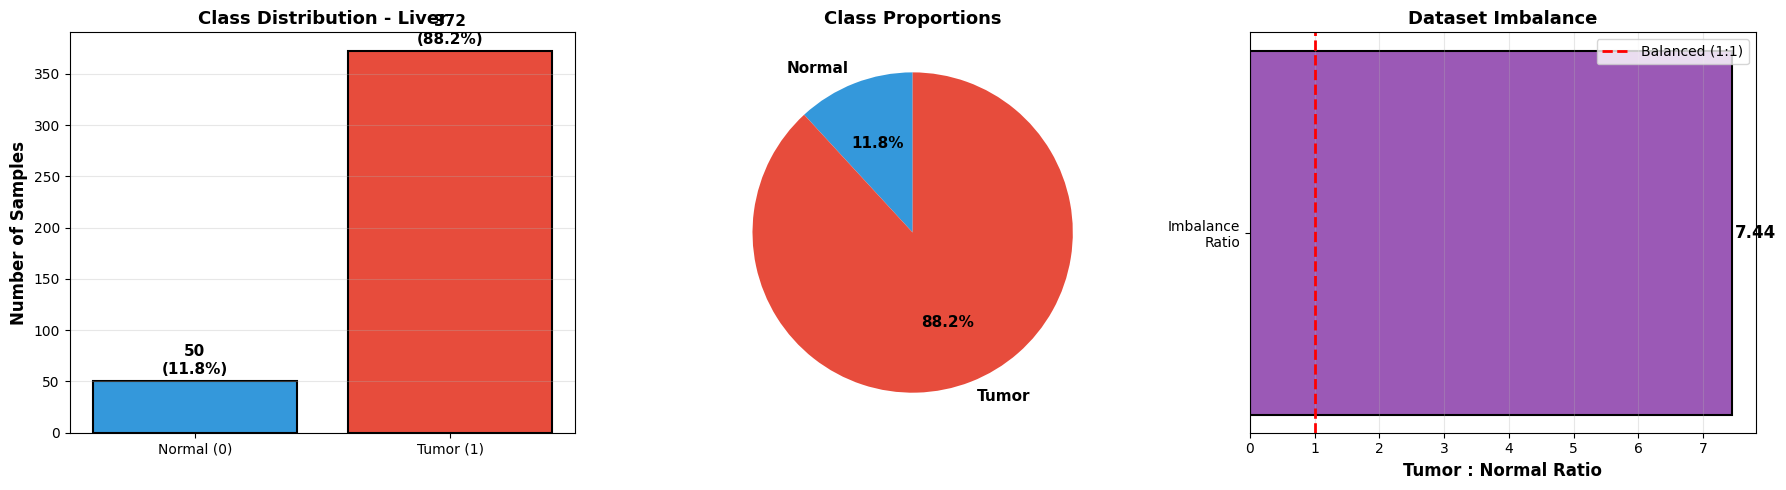

✓ Class distribution plot saved


In [6]:
# ============================================================================
# CLASS DISTRIBUTION ANALYSIS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Class counts bar chart
class_counts = y.value_counts().sort_index()
colors = ['#3498db', '#e74c3c']
axes[0].bar(['Normal (0)', 'Tumor (1)'], class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title(f'Class Distribution - {DATASET_NAME.capitalize()}', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (idx, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + max(class_counts)*0.02, f'{count}\n({count/len(y)*100:.1f}%)', 
                ha='center', fontsize=11, fontweight='bold')

# Plot 2: Pie chart
axes[1].pie(class_counts.values, labels=['Normal', 'Tumor'], autopct='%1.1f%%', 
           colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Class Proportions', fontsize=13, fontweight='bold')

# Plot 3: Imbalance ratio visualization
imbalance_ratio = class_counts[1] / class_counts[0]
axes[2].barh(['Imbalance\nRatio'], [imbalance_ratio], color='#9b59b6', edgecolor='black', linewidth=1.5)
axes[2].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Balanced (1:1)')
axes[2].set_xlabel('Tumor : Normal Ratio', fontsize=12, fontweight='bold')
axes[2].set_title('Dataset Imbalance', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(axis='x', alpha=0.3)
axes[2].text(imbalance_ratio + 0.05, 0, f'{imbalance_ratio:.2f}', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Class distribution plot saved")


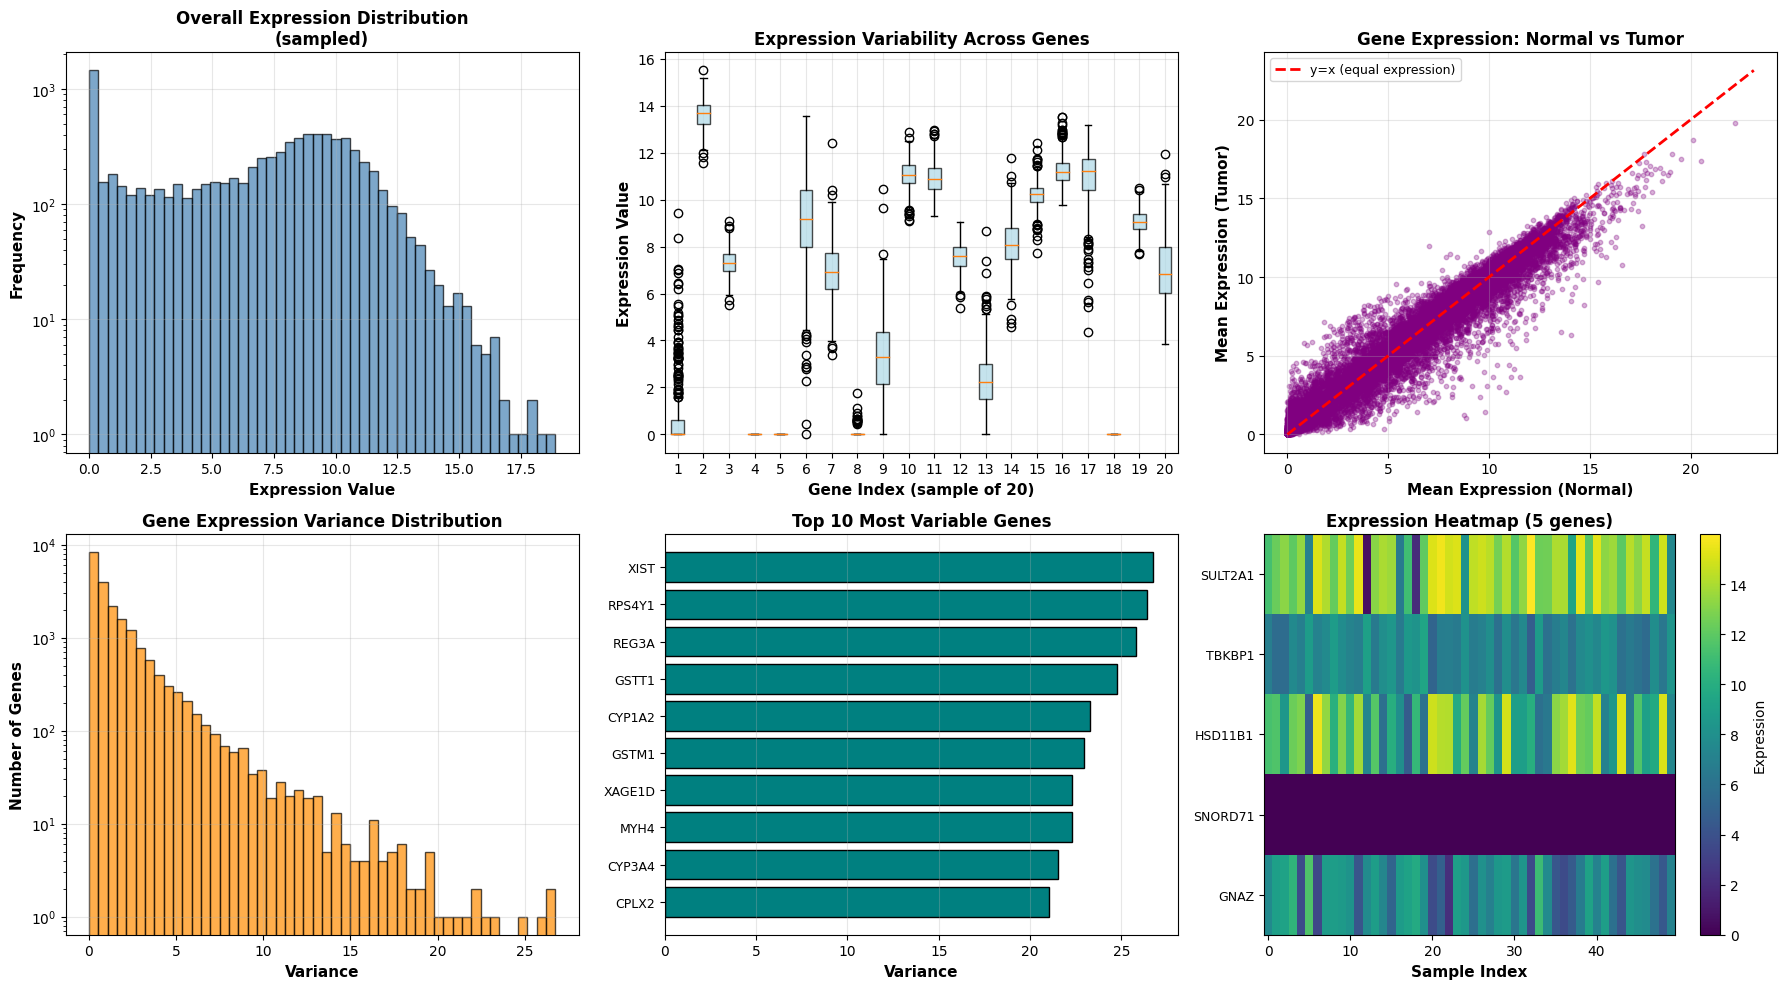

✓ Gene expression distribution plots saved


In [7]:
# ============================================================================
# GENE EXPRESSION DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Select 5 random genes for visualization
np.random.seed(RANDOM_STATE)
sample_genes = np.random.choice(X_raw.columns, size=5, replace=False)

# Plot 1: Overall expression distribution (log scale)
axes[0, 0].hist(X_raw.values.flatten()[::1000], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Expression Value', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Overall Expression Distribution\n(sampled)', fontsize=12, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Expression range per gene (boxplot sample)
sample_100_genes = np.random.choice(X_raw.columns, size=100, replace=False)
axes[0, 1].boxplot([X_raw[gene].values for gene in sample_100_genes[:20]], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 1].set_xlabel('Gene Index (sample of 20)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Expression Value', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Expression Variability Across Genes', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Mean expression per class
mean_normal = X_raw[y == 0].mean(axis=0)
mean_tumor = X_raw[y == 1].mean(axis=0)
axes[0, 2].scatter(mean_normal, mean_tumor, alpha=0.3, s=10, color='purple')
axes[0, 2].plot([X_raw.min().min(), X_raw.max().max()], 
               [X_raw.min().min(), X_raw.max().max()], 
               'r--', linewidth=2, label='y=x (equal expression)')
axes[0, 2].set_xlabel('Mean Expression (Normal)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Mean Expression (Tumor)', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Gene Expression: Normal vs Tumor', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(alpha=0.3)

# Plot 4: Gene variance distribution
gene_variance = X_raw.var(axis=0)
axes[1, 0].hist(gene_variance, bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Variance', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Number of Genes', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Gene Expression Variance Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 5: Top 10 most variable genes
top_var_genes = gene_variance.nlargest(10)
axes[1, 1].barh(range(10), top_var_genes.values, color='teal', edgecolor='black')
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels([g[:20] for g in top_var_genes.index], fontsize=9)
axes[1, 1].set_xlabel('Variance', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top 10 Most Variable Genes', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

# Plot 6: Expression heatmap for sample genes
sample_idx = np.random.choice(X_raw.shape[0], size=min(50, X_raw.shape[0]), replace=False)
sample_data = X_raw.iloc[sample_idx][sample_genes[:5]]
im = axes[1, 2].imshow(sample_data.T, aspect='auto', cmap='viridis', interpolation='nearest')
axes[1, 2].set_yticks(range(len(sample_genes[:5])))
axes[1, 2].set_yticklabels([g[:15] for g in sample_genes[:5]], fontsize=9)
axes[1, 2].set_xlabel('Sample Index', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Expression Heatmap (5 genes)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1, 2], label='Expression')

plt.tight_layout()
plt.savefig('/kaggle/working/expression_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gene expression distribution plots saved")


Computing differential expression between Normal and Tumor samples...

✓ Differential expression analysis complete

Top 10 Differentially Expressed Genes:
    Gene  Log2_Fold_Change       P_Value
  SFTA1P         20.992457 5.776738e-103
 GAGE12D         20.567701  4.793226e-20
  GAGE2D         20.534656  1.629812e-19
  GABRG2         20.015453  2.252646e-23
     VCY         20.001017  9.823293e-16
C20orf70         19.908534  1.300922e-23
   GAGE1         19.890901  3.622080e-14
  GAGE2A         19.871155  1.477953e-15
  GAGE2B         19.794145  7.431668e-11
 RBMY1A1         19.772300  5.360121e-16


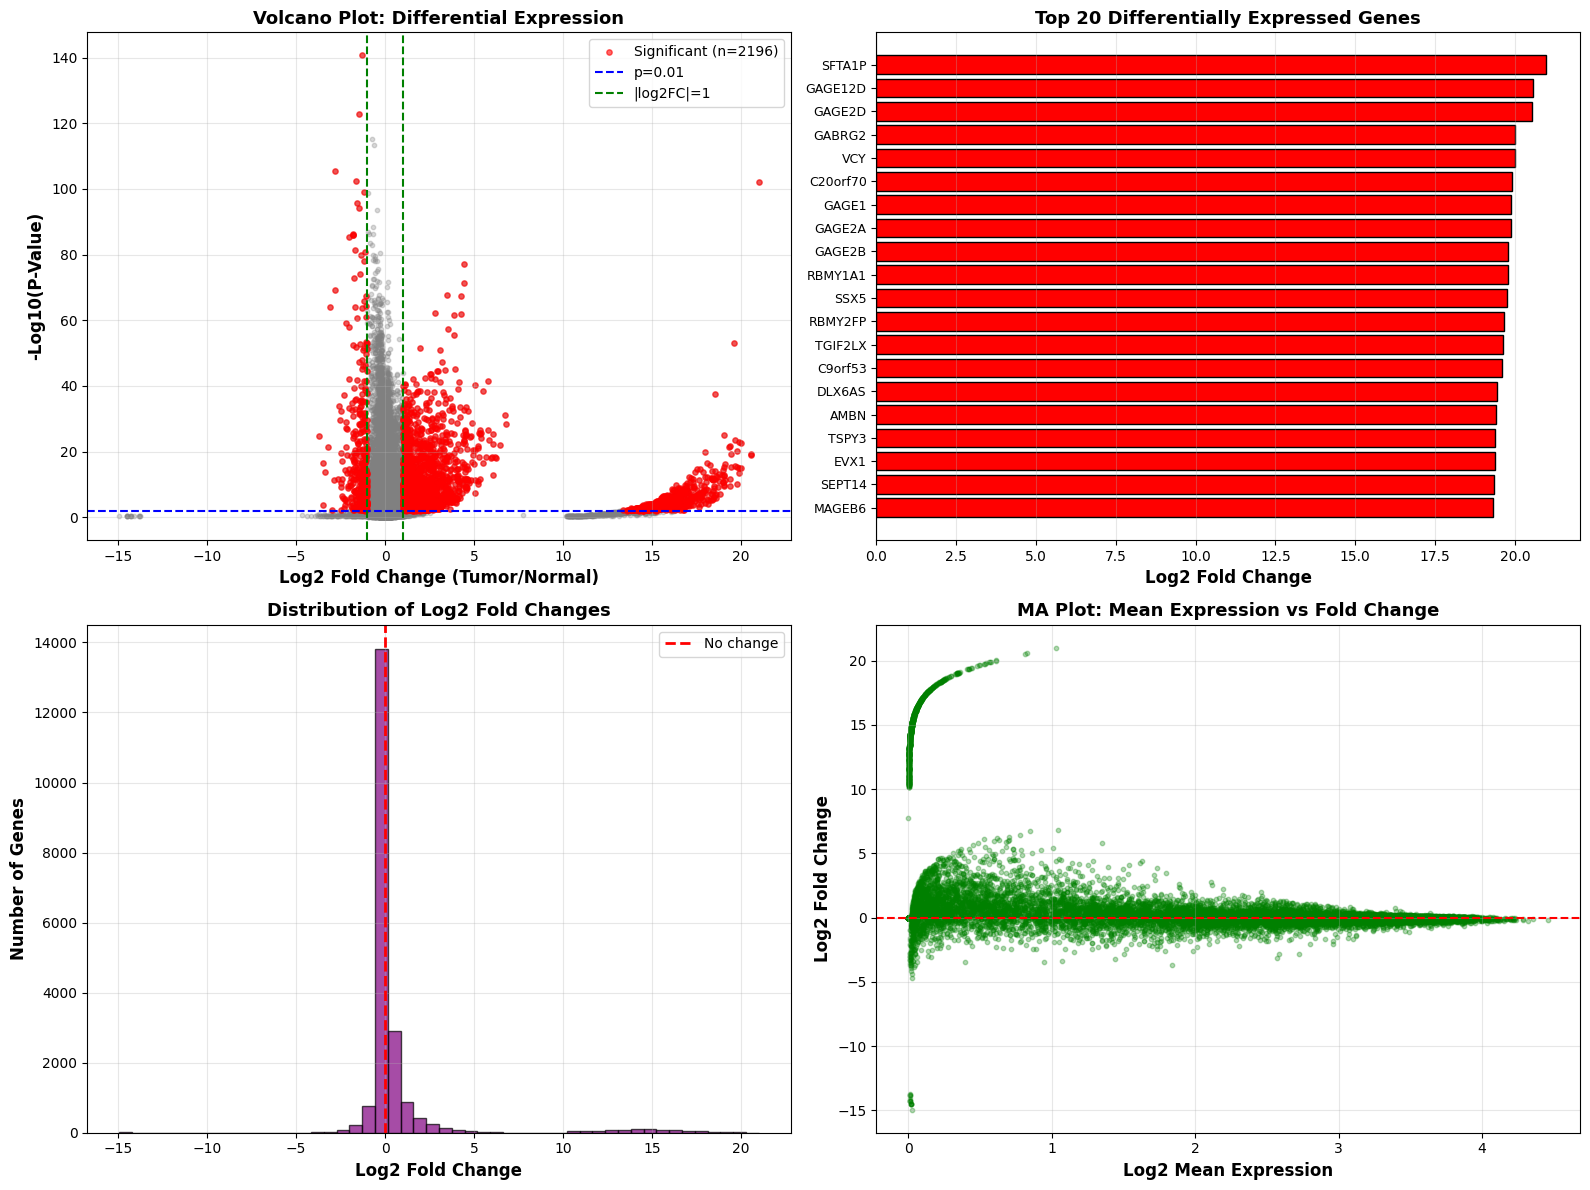


✓ Differential expression results saved to: /kaggle/working/differential_expression_results.csv


In [8]:
# ============================================================================
# DIFFERENTIAL EXPRESSION ANALYSIS (Normal vs Tumor)
# ============================================================================

from scipy import stats

print("Computing differential expression between Normal and Tumor samples...")

# Separate data by class
X_normal = X_raw[y == 0]
X_tumor = X_raw[y == 1]

# Compute statistics
diff_stats = pd.DataFrame({
    'Gene': X_raw.columns,
    'Mean_Normal': X_normal.mean(axis=0).values,
    'Mean_Tumor': X_tumor.mean(axis=0).values,
    'Std_Normal': X_normal.std(axis=0).values,
    'Std_Tumor': X_tumor.std(axis=0).values,
})

# Calculate fold change and log fold change
diff_stats['Fold_Change'] = (diff_stats['Mean_Tumor'] + 1e-6) / (diff_stats['Mean_Normal'] + 1e-6)
diff_stats['Log2_Fold_Change'] = np.log2(diff_stats['Fold_Change'])

# T-test for each gene
p_values = []
for gene in X_raw.columns:
    _, p_val = stats.ttest_ind(X_normal[gene], X_tumor[gene], equal_var=False)
    p_values.append(p_val)

diff_stats['P_Value'] = p_values
diff_stats['Abs_Log2_FC'] = np.abs(diff_stats['Log2_Fold_Change'])

# Sort by absolute log fold change
diff_stats = diff_stats.sort_values('Abs_Log2_FC', ascending=False)

print(f"\n✓ Differential expression analysis complete")
print(f"\nTop 10 Differentially Expressed Genes:")
print(diff_stats[['Gene', 'Log2_Fold_Change', 'P_Value']].head(10).to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Volcano plot
axes[0, 0].scatter(diff_stats['Log2_Fold_Change'], 
                  -np.log10(diff_stats['P_Value'] + 1e-300),
                  alpha=0.3, s=10, color='gray')

# Highlight significant genes (p < 0.01 and |log2FC| > 1)
significant = (diff_stats['P_Value'] < 0.01) & (diff_stats['Abs_Log2_FC'] > 1)
axes[0, 0].scatter(diff_stats.loc[significant, 'Log2_Fold_Change'],
                  -np.log10(diff_stats.loc[significant, 'P_Value'] + 1e-300),
                  alpha=0.6, s=15, color='red', label=f'Significant (n={significant.sum()})')

axes[0, 0].axhline(y=-np.log10(0.01), color='blue', linestyle='--', linewidth=1.5, label='p=0.01')
axes[0, 0].axvline(x=-1, color='green', linestyle='--', linewidth=1.5)
axes[0, 0].axvline(x=1, color='green', linestyle='--', linewidth=1.5, label='|log2FC|=1')
axes[0, 0].set_xlabel('Log2 Fold Change (Tumor/Normal)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('-Log10(P-Value)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Volcano Plot: Differential Expression', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Top 20 genes by fold change
top20_genes = diff_stats.head(20)
colors = ['red' if fc > 0 else 'blue' for fc in top20_genes['Log2_Fold_Change']]
axes[0, 1].barh(range(20), top20_genes['Log2_Fold_Change'].values, color=colors, edgecolor='black')
axes[0, 1].set_yticks(range(20))
axes[0, 1].set_yticklabels([g[:25] for g in top20_genes['Gene'].values], fontsize=9)
axes[0, 1].set_xlabel('Log2 Fold Change', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Top 20 Differentially Expressed Genes', fontsize=13, fontweight='bold')
axes[0, 1].axvline(x=0, color='black', linewidth=1.5)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Distribution of fold changes
axes[1, 0].hist(diff_stats['Log2_Fold_Change'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
axes[1, 0].set_xlabel('Log2 Fold Change', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Genes', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribution of Log2 Fold Changes', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Plot 4: MA plot (Mean vs Fold Change)
mean_expr = (diff_stats['Mean_Normal'] + diff_stats['Mean_Tumor']) / 2
axes[1, 1].scatter(np.log2(mean_expr + 1), diff_stats['Log2_Fold_Change'], 
                  alpha=0.3, s=10, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_xlabel('Log2 Mean Expression', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Log2 Fold Change', fontsize=12, fontweight='bold')
axes[1, 1].set_title('MA Plot: Mean Expression vs Fold Change', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/differential_expression.png', dpi=150, bbox_inches='tight')
plt.show()

# Save differential expression results
diff_stats.to_csv('/kaggle/working/differential_expression_results.csv', index=False)
print("\n✓ Differential expression results saved to: /kaggle/working/differential_expression_results.csv")


Min–Max normalization

In [9]:
scaler = MinMaxScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_norm.describe().T.head()


,count,mean,std,min,25%,50%,75%,max
ARHGEF10L,422.0,0.573314,0.165756,0.0,0.468830,0.588123,0.683864,1.0
HIF3A,422.0,0.366805,0.145216,0.0,0.271812,0.362998,0.437139,1.0
RNF17,422.0,0.090772,0.211861,0.0,0.000000,0.000000,0.000000,1.0
RNF10,422.0,0.429975,0.138912,0.0,0.351899,0.429374,0.511597,1.0
RNF11,422.0,0.590225,0.156054,0.0,0.487570,0.617381,0.697399,1.0


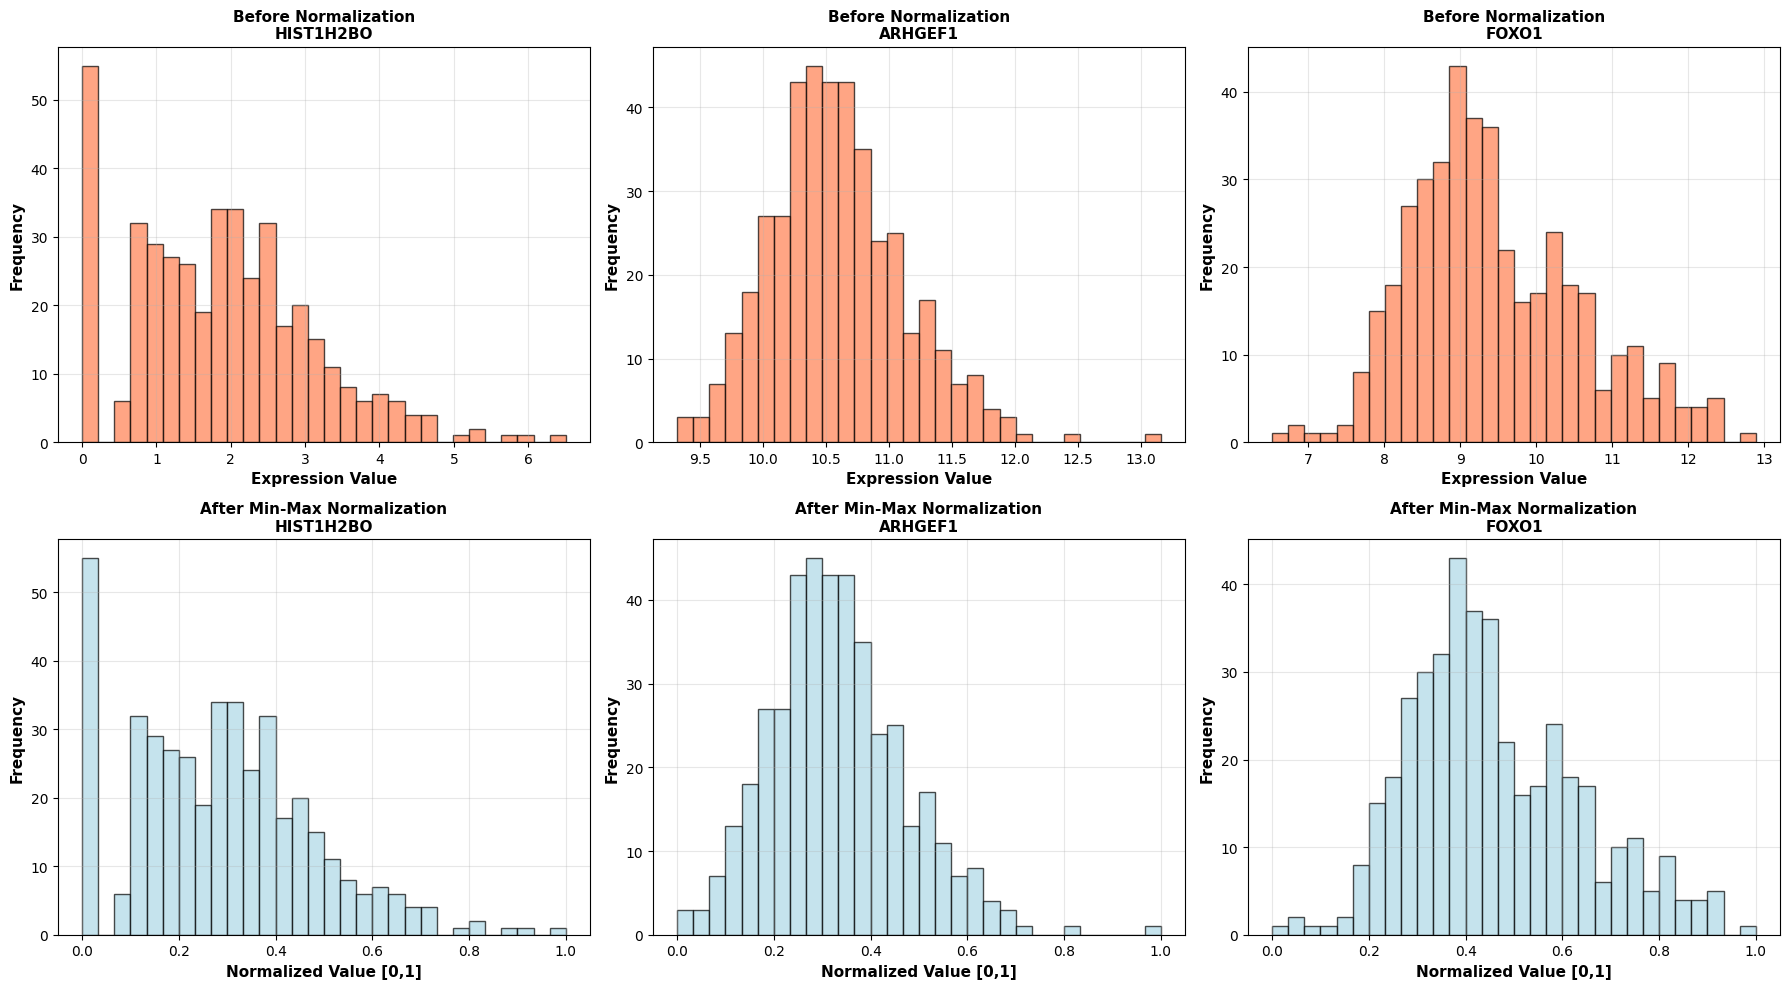

✓ Normalization effect visualization saved

Normalization Statistics:
Metric               Before          After
--------------------------------------------------
Min                  0.0000          0.0000
Max                  23.1389         1.0000
Mean                 6.1681          0.4047
Std (mean)           1.0378          0.1555


In [10]:
# ============================================================================
# NORMALIZATION EFFECT VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Select 3 genes for comparison
sample_genes = np.random.choice(X_raw.columns, size=3, replace=False)

for i, gene in enumerate(sample_genes):
    # Before normalization
    axes[0, i].hist(X_raw[gene], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[0, i].set_xlabel('Expression Value', fontsize=11, fontweight='bold')
    axes[0, i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0, i].set_title(f'Before Normalization\n{gene[:20]}', fontsize=11, fontweight='bold')
    axes[0, i].grid(alpha=0.3)
    
    # After normalization
    axes[1, i].hist(X_norm[gene], bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    axes[1, i].set_xlabel('Normalized Value [0,1]', fontsize=11, fontweight='bold')
    axes[1, i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1, i].set_title(f'After Min-Max Normalization\n{gene[:20]}', fontsize=11, fontweight='bold')
    axes[1, i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/normalization_effect.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Normalization effect visualization saved")

# Summary statistics comparison
print("\nNormalization Statistics:")
print(f"{'Metric':<20} {'Before':<15} {'After'}")
print("-" * 50)
print(f"{'Min':<20} {X_raw.min().min():<15.4f} {X_norm.min().min():.4f}")
print(f"{'Max':<20} {X_raw.max().max():<15.4f} {X_norm.max().max():.4f}")
print(f"{'Mean':<20} {X_raw.mean().mean():<15.4f} {X_norm.mean().mean():.4f}")
print(f"{'Std (mean)':<20} {X_raw.std().mean():<15.4f} {X_norm.std().mean():.4f}")


Stratified train/validation split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print(X_train.shape, X_test.shape, y_train.value_counts().to_dict(), y_test.value_counts().to_dict())


(337, 20530) (85, 20530) {1: 297, 0: 40} {1: 75, 0: 10}


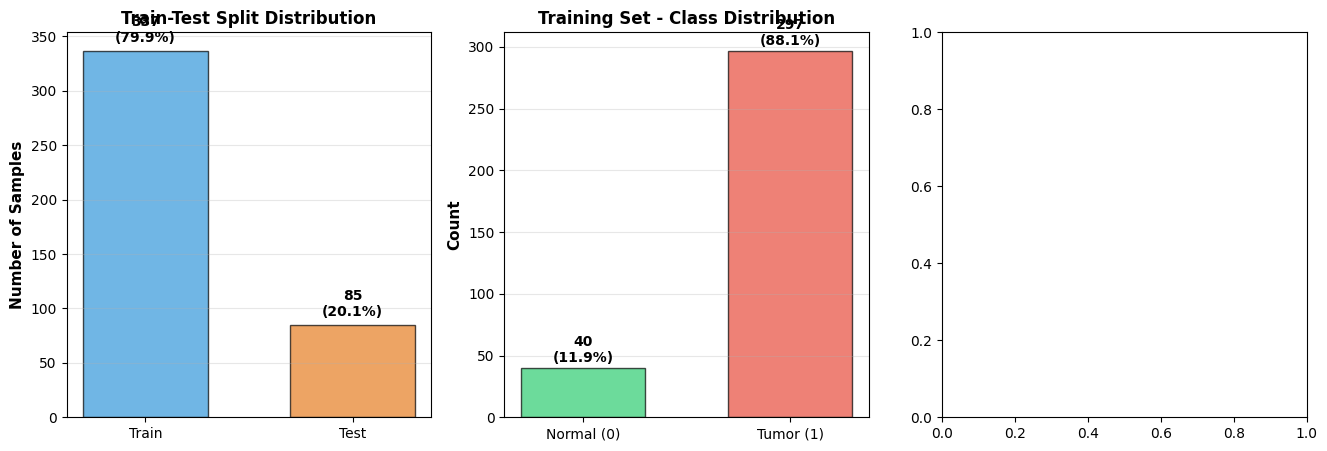

In [12]:
# ============================================================================
# TRAIN-TEST SPLIT VALIDATION & VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# -------------------------------------------------------------------------
# Plot 1: Overall Sample Distribution (Train vs Test)
# -------------------------------------------------------------------------
split_data = pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Count': [len(y_train), len(y_test)],
    'Percentage': [len(y_train)/(len(y_train)+len(y_test))*100, 
                   len(y_test)/(len(y_train)+len(y_test))*100]
})

bars = axes[0].bar(split_data['Split'], split_data['Count'], 
                   color=['#3498db', '#e67e22'], 
                   alpha=0.7, edgecolor='black', width=0.6)
axes[0].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0].set_title('Train-Test Split Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count and percentage labels on bars
for i, (bar, row) in enumerate(zip(bars, split_data.iterrows())):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(row[1]["Count"])}\n({row[1]["Percentage"]:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# -------------------------------------------------------------------------
# Plot 2: Class Distribution in Training Set
# -------------------------------------------------------------------------
train_class_dist = y_train.value_counts().sort_index()
train_labels = ['Normal (0)', 'Tumor (1)']
train_colors = ['#2ecc71', '#e74c3c']

bars = axes[1].bar(train_labels, train_class_dist.values, 
                   color=train_colors, alpha=0.7, edgecolor='black', width=0.6)
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('Training Set - Class Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add count and percentage labels
for i, (bar, val) in enumerate(zip(bars, train_class_dist.values)):
    height = bar.get_height()
    pct = 100 * val / len(y_train)
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{int(val)}\n({pct:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# -------------------------------------------------------------------------
# Plot 3: Class Distribution in Test Set
# -------------------------------------------------------------------------
test_class_dist = y_test.value_counts().sort_index()


Binarilization (KBinsDiscretizer with quantile strategy, one-hot dense)

In [13]:
disc = KBinsDiscretizer(n_bins=N_BINS, encode="onehot-dense", strategy="quantile")
Xb_train = disc.fit_transform(X_train)
Xb_test  = disc.transform(X_test)

# Build names only for selected features later to save memory; we will generate names on demand
n_features = X_train.shape[1]
print(f"Original features: {n_features}, after binarilization (one-hot): {Xb_train.shape[1]}")


Original features: 20530, after binarilization (one-hot): 172639


Generating binarization visualization...
Binary sample shape: (20, 10) (should be (20, 10))


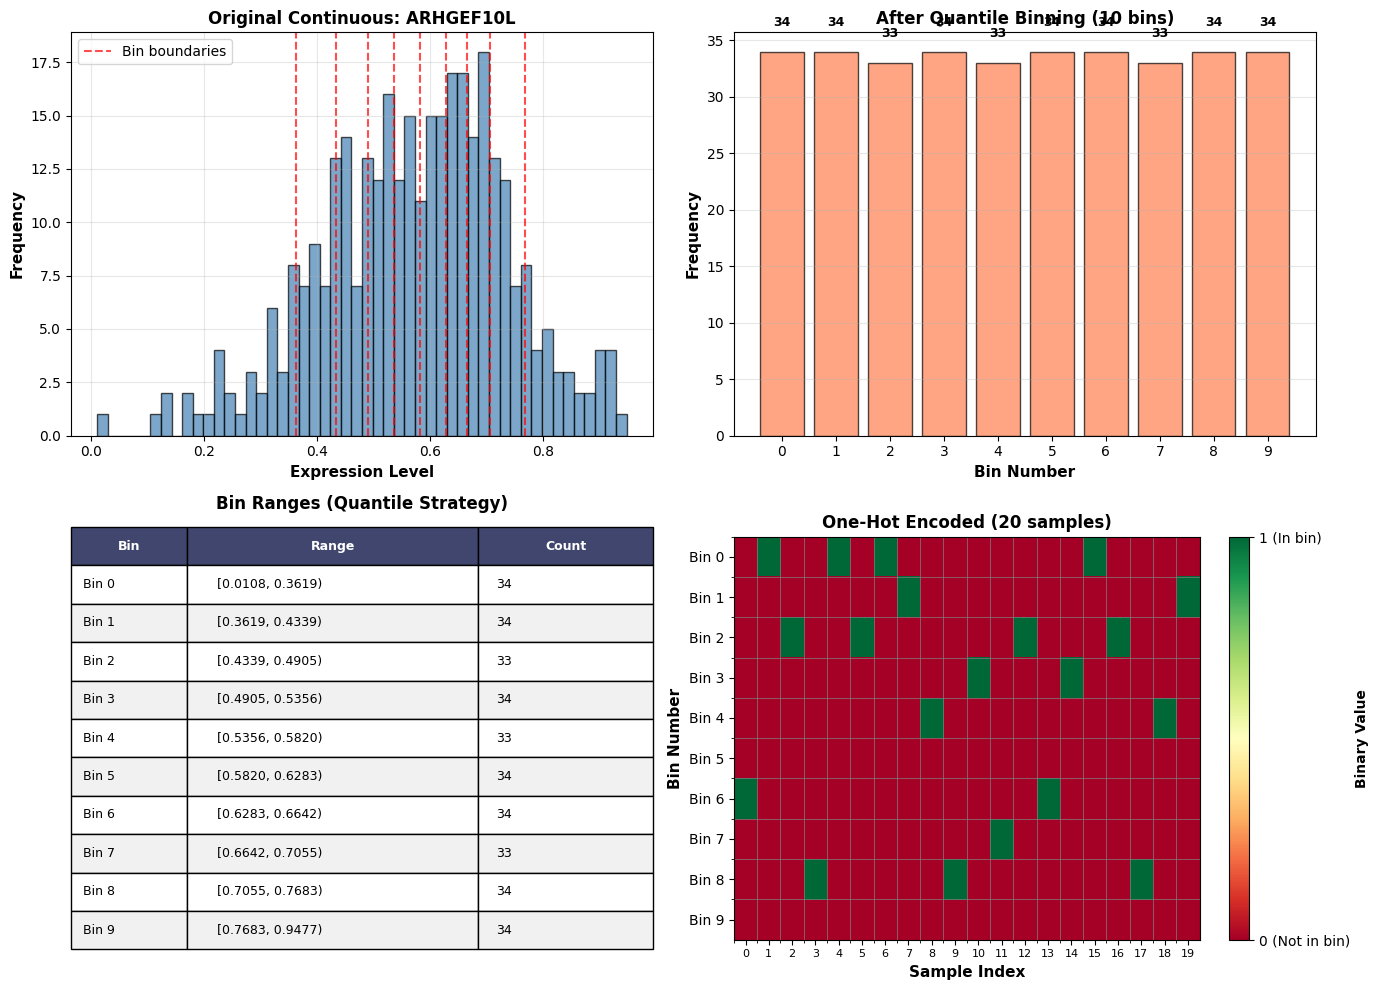


BINARIZATION SUMMARY

Demo Gene: ARHGEF10L
Original features: 20530
After binarization: 172639 (10 bins × 20530 genes)

Bin Strategy: Quantile (equal-frequency bins)
Encoding: One-hot dense (each sample has exactly 1 active bin per gene)

Bin Edge Values:
  Bin 0: [0.010799, 0.361866)
  Bin 1: [0.361866, 0.433924)
  Bin 2: [0.433924, 0.490496)
  Bin 3: [0.490496, 0.535568)
  Bin 4: [0.535568, 0.582047)
  Bin 5: [0.582047, 0.628311)
  Bin 6: [0.628311, 0.664203)
  Bin 7: [0.664203, 0.705514)
  Bin 8: [0.705514, 0.768314)
  Bin 9: [0.768314, 0.947656)

✓ One-hot encoding verified: Each sample has exactly 1 active bin

✓ Binarization visualization complete


In [14]:
# ============================================================================
# BINARIZATION VISUALIZATION - CORRECTED
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

print("Generating binarization visualization...")

# Select one gene to demonstrate binarization
demo_gene_idx = 0
demo_gene = X_train.columns[demo_gene_idx]
demo_values = X_train[demo_gene].values

# Create a separate discretizer for demonstration (ordinal encoding to show bins)
demo_discretizer = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='quantile')
demo_discretizer.fit(demo_values.reshape(-1, 1))
bin_edges = demo_discretizer.bin_edges_[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -------------------------------------------------------------------------
# Plot 1: Original continuous distribution with bin boundaries
# -------------------------------------------------------------------------
axes[0, 0].hist(demo_values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Expression Level', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Original Continuous: {demo_gene[:40]}', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Add bin boundaries as vertical lines
for i, edge in enumerate(bin_edges[1:-1], 1):
    axes[0, 0].axvline(edge, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
                       label='Bin boundaries' if i == 1 else '')
axes[0, 0].legend()

# -------------------------------------------------------------------------
# Plot 2: Binned distribution (after quantile discretization)
# -------------------------------------------------------------------------
binned_values = demo_discretizer.transform(demo_values.reshape(-1, 1)).ravel()
bin_counts = np.bincount(binned_values.astype(int), minlength=N_BINS)

axes[0, 1].bar(range(N_BINS), bin_counts, alpha=0.7, color='coral', edgecolor='black', width=0.8)
axes[0, 1].set_xlabel('Bin Number', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'After Quantile Binning ({N_BINS} bins)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(N_BINS))
axes[0, 1].grid(alpha=0.3, axis='y')

# Add count labels
for i, count in enumerate(bin_counts):
    axes[0, 1].text(i, count + 2, str(int(count)), 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# -------------------------------------------------------------------------
# Plot 3: Bin ranges table
# -------------------------------------------------------------------------
bin_info = []
for i in range(N_BINS):
    bin_info.append([
        f"Bin {i}",
        f"[{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f})",
        f"{bin_counts[i]}"
    ])

axes[1, 0].axis('tight')
axes[1, 0].axis('off')
table = axes[1, 0].table(
    cellText=bin_info,
    colLabels=['Bin', 'Range', 'Count'],
    loc='center',
    cellLoc='left',
    colWidths=[0.2, 0.5, 0.3]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, N_BINS + 1):
    color = '#f1f1f2' if i % 2 == 0 else 'white'
    for j in range(3):
        table[(i, j)].set_facecolor(color)

axes[1, 0].set_title('Bin Ranges (Quantile Strategy)', fontsize=12, fontweight='bold', pad=20)

# -------------------------------------------------------------------------
# Plot 4: One-hot encoding demonstration (first 20 samples)
# -------------------------------------------------------------------------
# CORRECTED: Extract the first N_BINS columns from the binarized data
# These correspond to the first gene's one-hot encoded bins
n_samples_demo = min(20, Xb_train.shape[0])

# The first gene's bins are at positions [0, 1, 2, ..., N_BINS-1]
binary_sample = Xb_train[:n_samples_demo, :N_BINS]

# Verify shape
print(f"Binary sample shape: {binary_sample.shape} (should be ({n_samples_demo}, {N_BINS}))")

if binary_sample.shape[1] == N_BINS:
    # Create heatmap
    im = axes[1, 1].imshow(binary_sample.T, cmap='RdYlGn', aspect='auto', 
                           interpolation='nearest', vmin=0, vmax=1)
    axes[1, 1].set_xlabel('Sample Index', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Bin Number', fontsize=11, fontweight='bold')
    axes[1, 1].set_title(f'One-Hot Encoded ({n_samples_demo} samples)', 
                        fontsize=12, fontweight='bold')
    axes[1, 1].set_yticks(range(N_BINS))
    axes[1, 1].set_yticklabels([f'Bin {i}' for i in range(N_BINS)])
    axes[1, 1].set_xticks(range(n_samples_demo))
    axes[1, 1].set_xticklabels(range(n_samples_demo), fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 1])
    cbar.set_label('Binary Value', fontsize=10, fontweight='bold')
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0 (Not in bin)', '1 (In bin)'])
    
    # Add grid
    axes[1, 1].set_xticks(np.arange(n_samples_demo) - 0.5, minor=True)
    axes[1, 1].set_yticks(np.arange(N_BINS) - 0.5, minor=True)
    axes[1, 1].grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
else:
    axes[1, 1].text(0.5, 0.5, 'Error: Binary sample shape mismatch', 
                   ha='center', va='center', transform=axes[1, 1].transAxes,
                   fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/binarization_effect.png', dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------------
# Console output
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("BINARIZATION SUMMARY")
print("="*80)
print(f"\nDemo Gene: {demo_gene}")
print(f"Original features: {X_train.shape[1]}")
print(f"After binarization: {Xb_train.shape[1]} ({N_BINS} bins × {X_train.shape[1]} genes)")
print(f"\nBin Strategy: Quantile (equal-frequency bins)")
print(f"Encoding: One-hot dense (each sample has exactly 1 active bin per gene)")
print(f"\nBin Edge Values:")
for i in range(N_BINS):
    print(f"  Bin {i}: [{bin_edges[i]:.6f}, {bin_edges[i+1]:.6f})")

# Verify one-hot property
sample_check = binary_sample.sum(axis=1)
if np.all(sample_check == 1):
    print(f"\n✓ One-hot encoding verified: Each sample has exactly 1 active bin")
else:
    print(f"\n⚠ Warning: One-hot encoding issue detected")

print("\n✓ Binarization visualization complete")
print("="*80)


Chi-square feature selection

In [15]:
# SelectKBest with chi2 expects non-negative features (satisfied by MinMax + one-hot)
selector = SelectKBest(score_func=chi2, k=min(K_SELECTED, Xb_train.shape[1]))
Xsel_train = selector.fit_transform(Xb_train, y_train)
Xsel_test  = selector.transform(Xb_test)

# Build readable names for selected features
# Map from original feature index and bin to a name: {col_idx, bin_idx}
selected_mask = selector.get_support(indices=True)
def selected_feature_names():
    names = []
    # For feature j in [0, n_features-1], its bins occupy positions [j*N_BINS .. j*N_BINS+N_BINS-1]
    for pos in selected_mask:
        j = pos // N_BINS
        b = pos % N_BINS
        names.append(f"{X_train.columns[j]}_bin_{b}")
    return names

sel_names = selected_feature_names()
print(f"Selected: {len(sel_names)} features")


Selected: 2000 features


CHI-SQUARE FEATURE SELECTION ANALYSIS

Total features after binarization: 172639
Features selected: 2000
Selection rate: 1.158%


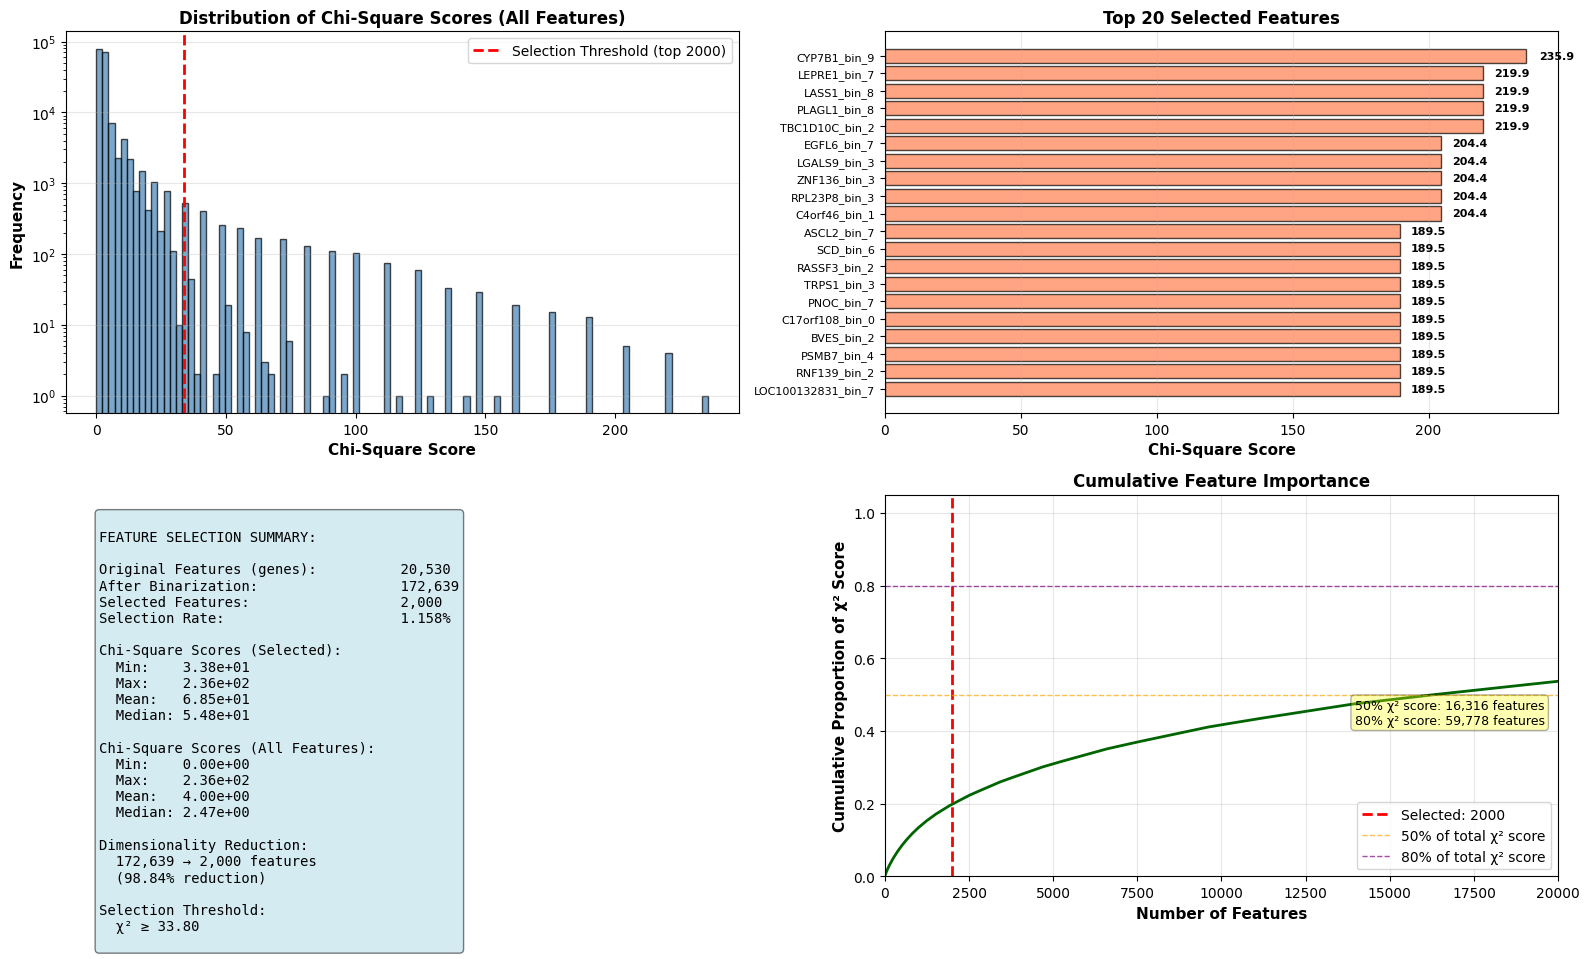


TOP 30 SELECTED FEATURES BY CHI-SQUARE SCORE
Rank   Feature Name                                       Chi² Score     
--------------------------------------------------------------------------------
1      CYP7B1_bin_9                                       235.8812       
2      LEPRE1_bin_7                                       219.8747       
3      LASS1_bin_8                                        219.8747       
4      PLAGL1_bin_8                                       219.8747       
5      TBC1D10C_bin_2                                     219.8747       
6      EGFL6_bin_7                                        204.4305       
7      LGALS9_bin_3                                       204.4305       
8      ZNF136_bin_3                                       204.4305       
9      RPL23P8_bin_3                                      204.4305       
10     C4orf46_bin_1                                      204.4305       
11     ASCL2_bin_7                                        1

In [16]:
# ============================================================================
# CHI-SQUARE FEATURE SELECTION ANALYSIS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*80)
print("CHI-SQUARE FEATURE SELECTION ANALYSIS")
print("="*80)

# -------------------------------------------------------------------------
# Get chi-square scores and selected feature information
# -------------------------------------------------------------------------
chi2_scores = selector.scores_  # All scores (before selection)
selected_mask = selector.get_support()  # Boolean mask of selected features
selected_indices = selector.get_support(indices=True)  # Integer indices

print(f"\nTotal features after binarization: {len(chi2_scores)}")
print(f"Features selected: {len(sel_names)}")
print(f"Selection rate: {100*len(sel_names)/len(chi2_scores):.3f}%")

# -------------------------------------------------------------------------
# Create visualizations
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# -------------------------------------------------------------------------
# Plot 1: Distribution of chi-square scores (all features)
# -------------------------------------------------------------------------
axes[0, 0].hist(chi2_scores, bins=100, alpha=0.7, color='steelblue', edgecolor='black')

# Add threshold line
if len(selected_indices) > 0:
    threshold = chi2_scores[selected_indices].min()
    axes[0, 0].axvline(threshold, color='red', linestyle='--', 
                       linewidth=2, label=f'Selection Threshold (top {K_SELECTED})')
    axes[0, 0].legend()

axes[0, 0].set_xlabel('Chi-Square Score', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Chi-Square Scores (All Features)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(alpha=0.3, axis='y')

# -------------------------------------------------------------------------
# Plot 2: Top 20 selected features by chi-square score
# -------------------------------------------------------------------------
# Get chi-square scores of SELECTED features only
selected_chi2_scores = chi2_scores[selected_indices]

# Sort to get top 20
top_20_idx_in_selected = np.argsort(selected_chi2_scores)[-20:][::-1]
top_20_scores = selected_chi2_scores[top_20_idx_in_selected]
top_20_names = [sel_names[i][:40] for i in top_20_idx_in_selected]  # Truncate long names

# Horizontal bar chart
y_pos = range(20)
axes[0, 1].barh(y_pos, top_20_scores, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels(top_20_names, fontsize=8)
axes[0, 1].set_xlabel('Chi-Square Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top 20 Selected Features', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Add value labels
for i, score in enumerate(top_20_scores):
    axes[0, 1].text(score + score*0.02, i, f'{score:.1f}', 
                   va='center', fontsize=8, fontweight='bold')

# -------------------------------------------------------------------------
# Plot 3: Feature selection statistics (text summary)
# -------------------------------------------------------------------------
selection_stats = f"""
FEATURE SELECTION SUMMARY:

Original Features (genes):          {X_train.shape[1]:,}
After Binarization:                 {len(chi2_scores):,}
Selected Features:                  {len(sel_names):,}
Selection Rate:                     {100*len(sel_names)/len(chi2_scores):.3f}%

Chi-Square Scores (Selected):
  Min:    {selected_chi2_scores.min():.2e}
  Max:    {selected_chi2_scores.max():.2e}
  Mean:   {selected_chi2_scores.mean():.2e}
  Median: {np.median(selected_chi2_scores):.2e}

Chi-Square Scores (All Features):
  Min:    {chi2_scores.min():.2e}
  Max:    {chi2_scores.max():.2e}
  Mean:   {chi2_scores.mean():.2e}
  Median: {np.median(chi2_scores):.2e}

Dimensionality Reduction:
  {len(chi2_scores):,} → {len(sel_names):,} features
  ({100*(1-len(sel_names)/len(chi2_scores)):.2f}% reduction)

Selection Threshold:
  χ² ≥ {threshold:.2f}
"""

axes[1, 0].text(0.05, 0.95, selection_stats, transform=axes[1, 0].transAxes,
               fontsize=10, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[1, 0].axis('off')

# -------------------------------------------------------------------------
# Plot 4: Cumulative chi-square scores
# -------------------------------------------------------------------------
sorted_scores = np.sort(chi2_scores)[::-1]
cumsum_scores = np.cumsum(sorted_scores)
cumsum_pct = cumsum_scores / np.sum(sorted_scores)

axes[1, 1].plot(range(len(cumsum_pct)), cumsum_pct, linewidth=2, color='darkgreen')
axes[1, 1].axvline(K_SELECTED, color='red', linestyle='--', linewidth=2, 
                   label=f'Selected: {K_SELECTED}')
axes[1, 1].axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.7,
                   label='50% of total χ² score')
axes[1, 1].axhline(0.8, color='purple', linestyle='--', linewidth=1, alpha=0.7,
                   label='80% of total χ² score')

axes[1, 1].set_xlabel('Number of Features', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Proportion of χ² Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim([0, min(20000, len(cumsum_pct))])
axes[1, 1].set_ylim([0, 1.05])

# Find how many features contribute to 50% and 80%
feat_for_50pct = np.searchsorted(cumsum_pct, 0.5) + 1
feat_for_80pct = np.searchsorted(cumsum_pct, 0.8) + 1

axes[1, 1].text(0.98, 0.40, 
               f'50% χ² score: {feat_for_50pct:,} features\n80% χ² score: {feat_for_80pct:,} features',
               transform=axes[1, 1].transAxes, fontsize=9, ha='right',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('/kaggle/working/feature_selection_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------------
# Print top 30 selected features table
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("TOP 30 SELECTED FEATURES BY CHI-SQUARE SCORE")
print("="*80)
print(f"{'Rank':<6} {'Feature Name':<50} {'Chi² Score':<15}")
print("-"*80)

# Get top 30 from selected features
top_30_idx_in_selected = np.argsort(selected_chi2_scores)[-30:][::-1]

for rank, idx in enumerate(top_30_idx_in_selected, 1):
    feature_name = sel_names[idx]
    chi2_score = selected_chi2_scores[idx]
    
    # Truncate long names
    display_name = feature_name if len(feature_name) <= 48 else feature_name[:45] + "..."
    
    print(f"{rank:<6} {display_name:<50} {chi2_score:<15.4f}")

# -------------------------------------------------------------------------
# Additional insights
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("ADDITIONAL INSIGHTS")
print("="*80)

# Score distribution
print(f"\nScore Distribution:")
print(f"  Features with χ² > 100:   {np.sum(selected_chi2_scores > 100)}")
print(f"  Features with χ² > 50:    {np.sum(selected_chi2_scores > 50)}")
print(f"  Features with χ² > 10:    {np.sum(selected_chi2_scores > 10)}")
print(f"  Features with χ² > 1:     {np.sum(selected_chi2_scores > 1)}")

# Feature concentration
print(f"\nFeature Importance Concentration:")
print(f"  Top 10 features capture:   {100*cumsum_pct[9]:.2f}% of total χ² score")
print(f"  Top 100 features capture:  {100*cumsum_pct[99]:.2f}% of total χ² score")
print(f"  Top 1000 features capture: {100*cumsum_pct[999]:.2f}% of total χ² score")

print(f"\nFeatures needed for:")
print(f"  50% of χ² score: {feat_for_50pct:,} features ({100*feat_for_50pct/len(chi2_scores):.2f}% of all)")
print(f"  80% of χ² score: {feat_for_80pct:,} features ({100*feat_for_80pct/len(chi2_scores):.2f}% of all)")

# Save detailed feature scores
feature_scores_df = pd.DataFrame({
    'Feature': sel_names,
    'Chi2_Score': selected_chi2_scores,
    'Rank': range(1, len(sel_names) + 1)
}).sort_values('Chi2_Score', ascending=False).reset_index(drop=True)

feature_scores_df.to_csv('/kaggle/working/selected_features_chi2_scores.csv', index=False)

print("\n" + "="*80)
print("✓ Feature selection analysis complete")
print("  Files saved:")
print("    - /kaggle/working/feature_selection_analysis.png")
print("    - /kaggle/working/selected_features_chi2_scores.csv")
print("="*80)


GENE-LEVEL SELECTION ANALYSIS

Metric                                   Value               
--------------------------------------------------------------------------------
Total unique genes selected              1894
Total selected features (bins)           2000
Average bins per gene                    1.06
Median bins per gene                     1.0
Max bins from single gene                3 / 10
Min bins from single gene                1 / 10
Genes with all bins selected             0
Genes with only 1 bin selected           1790

Top 20 Genes by Number of Selected Bins:
--------------------------------------------------------------------------------
Rank   Gene Name                                     Bins     % of Max  
--------------------------------------------------------------------------------
1      SON                                           3        30.0%
2      ZSWIM3                                        3        30.0%
3      RNF13                                 

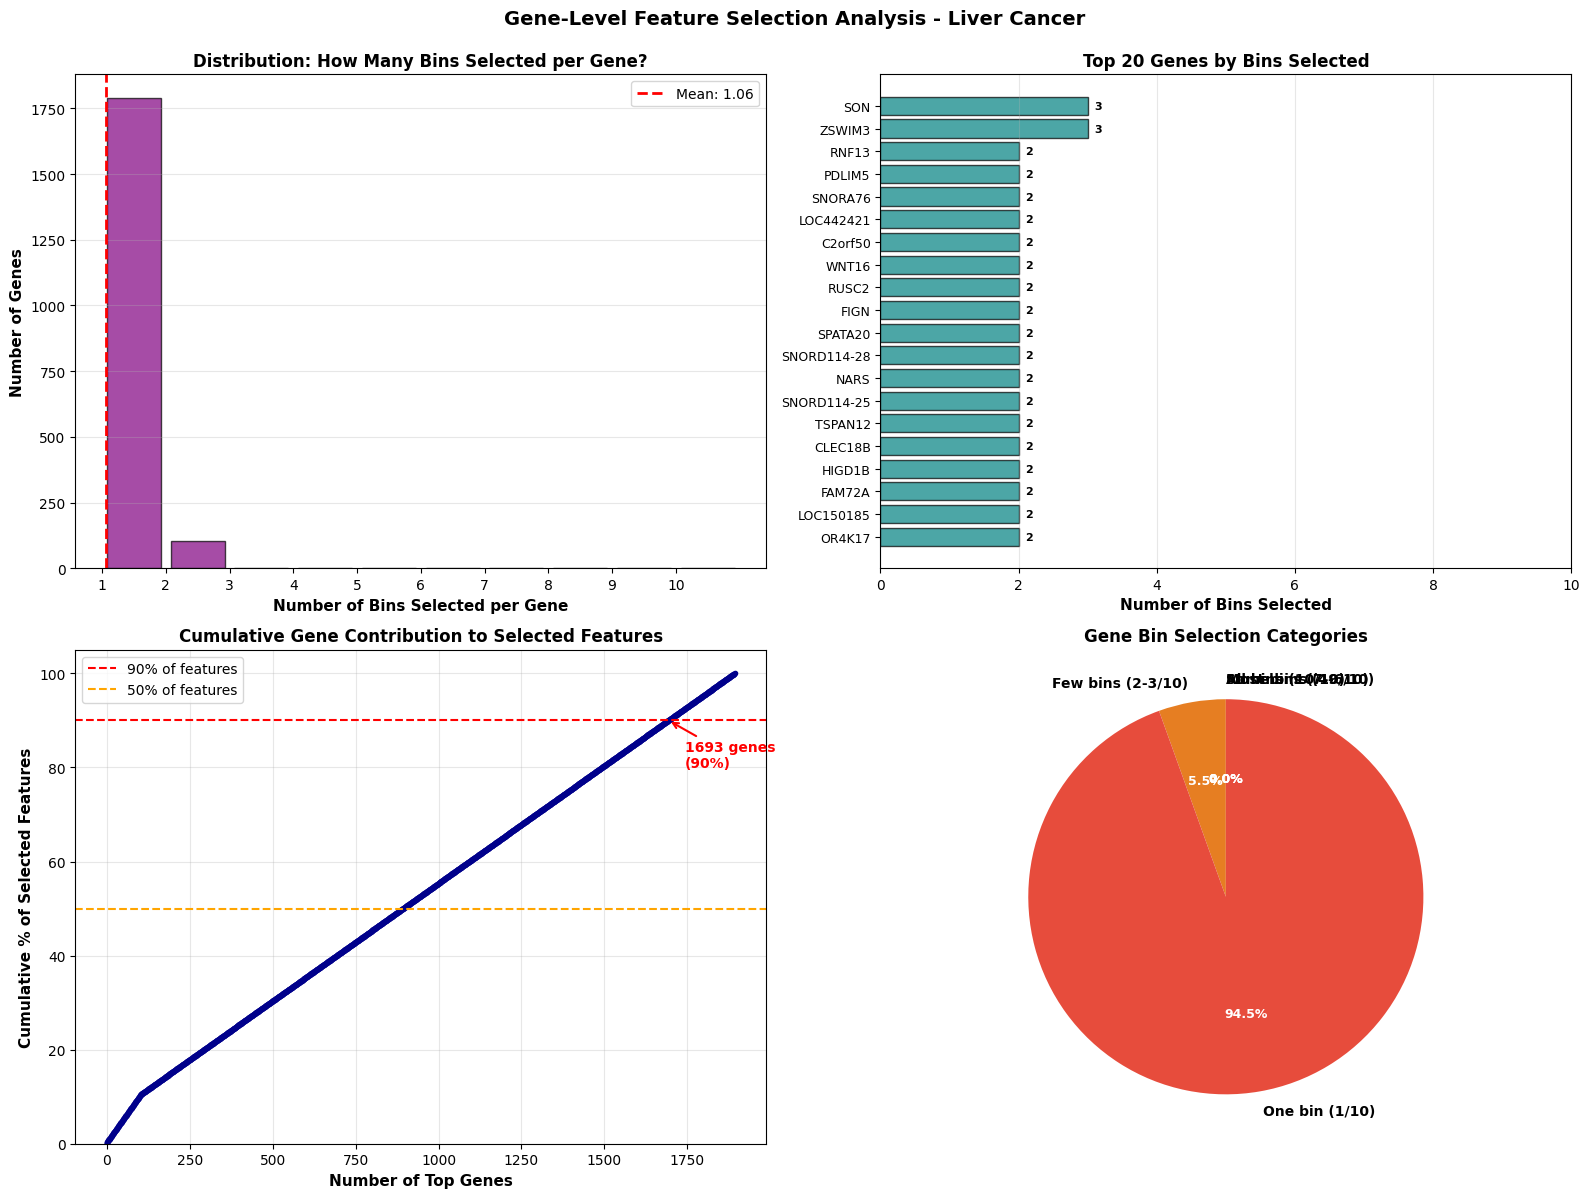


✓ Gene-level analysis complete
  - Visualization saved: /kaggle/working/gene_level_selection.png
  - Gene details saved: /kaggle/working/selected_genes_details.csv

Example: Gene 'RNF13'
  Selected bins: [3, 4]
  Total: 2 out of 10 bins
  Features in model: ['RNF13_bin_3', 'RNF13_bin_4']...


In [17]:
# ============================================================================
# GENE-LEVEL SELECTION ANALYSIS
# Which original genes contribute the most to selected features?
# ============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------------------------------------------------
# Step 1: Extract gene names from selected binary features
# -------------------------------------------------------------------------
print("="*80)
print("GENE-LEVEL SELECTION ANALYSIS")
print("="*80)

selected_genes = {}
for feat_name in sel_names:
    if '_bin_' in feat_name:
        # Split feature name: "GENE_NAME_bin_5" -> ("GENE_NAME", "5")
        parts = feat_name.rsplit('_bin_', 1)
        gene = parts[0]
        bin_num = int(parts[1])
        
        if gene not in selected_genes:
            selected_genes[gene] = []
        selected_genes[gene].append(bin_num)

# -------------------------------------------------------------------------
# Step 2: Count bins per gene
# -------------------------------------------------------------------------
gene_bin_counts = {gene: len(bins) for gene, bins in selected_genes.items()}
gene_bin_df = pd.DataFrame(
    list(gene_bin_counts.items()), 
    columns=['Gene', 'Bins_Selected']
).sort_values('Bins_Selected', ascending=False)

# Add percentage column
gene_bin_df['Percentage'] = 100 * gene_bin_df['Bins_Selected'] / N_BINS

# -------------------------------------------------------------------------
# Step 3: Statistics
# -------------------------------------------------------------------------
print(f"\n{'Metric':<40} {'Value':<20}")
print("-"*80)
print(f"{'Total unique genes selected':<40} {len(selected_genes)}")
print(f"{'Total selected features (bins)':<40} {len(sel_names)}")
print(f"{'Average bins per gene':<40} {np.mean(list(gene_bin_counts.values())):.2f}")
print(f"{'Median bins per gene':<40} {np.median(list(gene_bin_counts.values())):.1f}")
print(f"{'Max bins from single gene':<40} {max(gene_bin_counts.values())} / {N_BINS}")
print(f"{'Min bins from single gene':<40} {min(gene_bin_counts.values())} / {N_BINS}")

# Genes with all bins selected
all_bins_genes = [g for g, c in gene_bin_counts.items() if c == N_BINS]
print(f"{'Genes with all bins selected':<40} {len(all_bins_genes)}")

# Genes with only 1 bin selected
single_bin_genes = [g for g, c in gene_bin_counts.items() if c == 1]
print(f"{'Genes with only 1 bin selected':<40} {len(single_bin_genes)}")

# -------------------------------------------------------------------------
# Step 4: Top genes summary table
# -------------------------------------------------------------------------
print(f"\nTop 20 Genes by Number of Selected Bins:")
print("-"*80)
print(f"{'Rank':<6} {'Gene Name':<45} {'Bins':<8} {'% of Max':<10}")
print("-"*80)

for rank, (idx, row) in enumerate(gene_bin_df.head(20).iterrows(), 1):
    gene_name = row['Gene'][:40]  # Truncate long names
    bins = row['Bins_Selected']
    pct = row['Percentage']
    print(f"{rank:<6} {gene_name:<45} {bins:<8} {pct:.1f}%")

# -------------------------------------------------------------------------
# Step 5: Visualizations
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribution of bins per gene (histogram)
axes[0, 0].hist(list(gene_bin_counts.values()), 
                bins=range(1, N_BINS+2), 
                alpha=0.7, color='purple', edgecolor='black', rwidth=0.85)
axes[0, 0].set_xlabel('Number of Bins Selected per Gene', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Genes', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution: How Many Bins Selected per Gene?', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(1, N_BINS+1))
axes[0, 0].grid(axis='y', alpha=0.3)

# Add annotation for mean
mean_bins = np.mean(list(gene_bin_counts.values()))
axes[0, 0].axvline(mean_bins, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_bins:.2f}')
axes[0, 0].legend()

# Plot 2: Top 20 genes by bins selected (horizontal bar)
top_genes = gene_bin_df.head(20)
y_pos = np.arange(len(top_genes))

bars = axes[0, 1].barh(y_pos, top_genes['Bins_Selected'].values, 
                       color='teal', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels([g[:35] for g in top_genes['Gene'].values], fontsize=9)
axes[0, 1].set_xlabel('Number of Bins Selected', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top 20 Genes by Bins Selected', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].set_xlim([0, N_BINS])

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_genes['Bins_Selected'].values)):
    axes[0, 1].text(val + 0.1, bar.get_y() + bar.get_height()/2, 
                    str(int(val)), va='center', fontsize=8, fontweight='bold')

# Plot 3: Cumulative gene contribution
sorted_counts = np.sort(list(gene_bin_counts.values()))[::-1]
cumsum_counts = np.cumsum(sorted_counts)
cumsum_pct = 100 * cumsum_counts / cumsum_counts[-1]

axes[1, 0].plot(range(len(cumsum_pct)), cumsum_pct, 
                linewidth=2.5, color='darkblue', marker='o', markersize=3)
axes[1, 0].axhline(90, color='red', linestyle='--', linewidth=1.5, 
                   label='90% of features')
axes[1, 0].axhline(50, color='orange', linestyle='--', linewidth=1.5, 
                   label='50% of features')
axes[1, 0].set_xlabel('Number of Top Genes', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Cumulative % of Selected Features', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Cumulative Gene Contribution to Selected Features', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 105])

# Find how many genes contribute to 90%
idx_90 = np.where(cumsum_pct >= 90)[0][0]
axes[1, 0].annotate(f'{idx_90} genes\n(90%)', 
                    xy=(idx_90, 90), xytext=(idx_90 + 50, 80),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=10, fontweight='bold', color='red')

# Plot 4: Pie chart - bin selection categories
categories = {
    'All bins (10/10)': len([g for g, c in gene_bin_counts.items() if c == N_BINS]),
    f'Most bins (7-9/{N_BINS})': len([g for g, c in gene_bin_counts.items() if 7 <= c < N_BINS]),
    f'Some bins (4-6/{N_BINS})': len([g for g, c in gene_bin_counts.items() if 4 <= c < 7]),
    f'Few bins (2-3/{N_BINS})': len([g for g, c in gene_bin_counts.items() if 2 <= c < 4]),
    f'One bin (1/{N_BINS})': len([g for g, c in gene_bin_counts.items() if c == 1])
}

colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c']
wedges, texts, autotexts = axes[1, 1].pie(
    categories.values(), 
    labels=categories.keys(), 
    autopct='%1.1f%%',
    colors=colors_pie, 
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)

# Make percentage text white for visibility
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)

axes[1, 1].set_title('Gene Bin Selection Categories', fontsize=12, fontweight='bold')

plt.suptitle(f'Gene-Level Feature Selection Analysis - {DATASET_NAME.capitalize()} Cancer', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/gene_level_selection.png', dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------------
# Step 6: Save detailed gene table to CSV
# -------------------------------------------------------------------------
# Add which bins are selected for each gene
gene_details = []
for gene, bins in selected_genes.items():
    gene_details.append({
        'Gene': gene,
        'Bins_Selected': len(bins),
        'Percentage_of_Max': 100 * len(bins) / N_BINS,
        'Bin_Numbers': ','.join(map(str, sorted(bins)))
    })

gene_details_df = pd.DataFrame(gene_details).sort_values('Bins_Selected', ascending=False)
gene_details_df.to_csv('/kaggle/working/selected_genes_details.csv', index=False)

print(f"\n✓ Gene-level analysis complete")
print(f"  - Visualization saved: /kaggle/working/gene_level_selection.png")
print(f"  - Gene details saved: /kaggle/working/selected_genes_details.csv")
print("="*80)

# -------------------------------------------------------------------------
# Bonus: Show example of one gene's bins
# -------------------------------------------------------------------------
if len(selected_genes) > 0:
    example_gene = list(selected_genes.keys())[0]
    example_bins = selected_genes[example_gene]
    
    print(f"\nExample: Gene '{example_gene}'")
    print(f"  Selected bins: {sorted(example_bins)}")
    print(f"  Total: {len(example_bins)} out of {N_BINS} bins")
    print(f"  Features in model: {[f'{example_gene}_bin_{b}' for b in sorted(example_bins)][:3]}...")


CLASS IMBALANCE ANALYSIS & MITIGATION STRATEGY

Class Distribution:
  Training Set:
    Class 0 (Normal): 40 (11.9%)
    Class 1 (Tumor):  297 (88.1%)
  Test Set:
    Class 0 (Normal): 10 (11.8%)
    Class 1 (Tumor):  75 (88.2%)

Imbalance Analysis:
  Minority class: 0 (40 samples)
  Majority class: 1 (297 samples)
  Imbalance ratio: 7.42:1

IMBALANCE SEVERITY: MODERATE IMBALANCE
RECOMMENDATION: Use class_weight='balanced' OR SMOTE (optional)

Computed Class Weights (for sklearn models):
  Class 0 (Normal): 4.2125
  Class 1 (Tumor):  0.5673
  Ratio (Normal/Tumor): 7.43:1


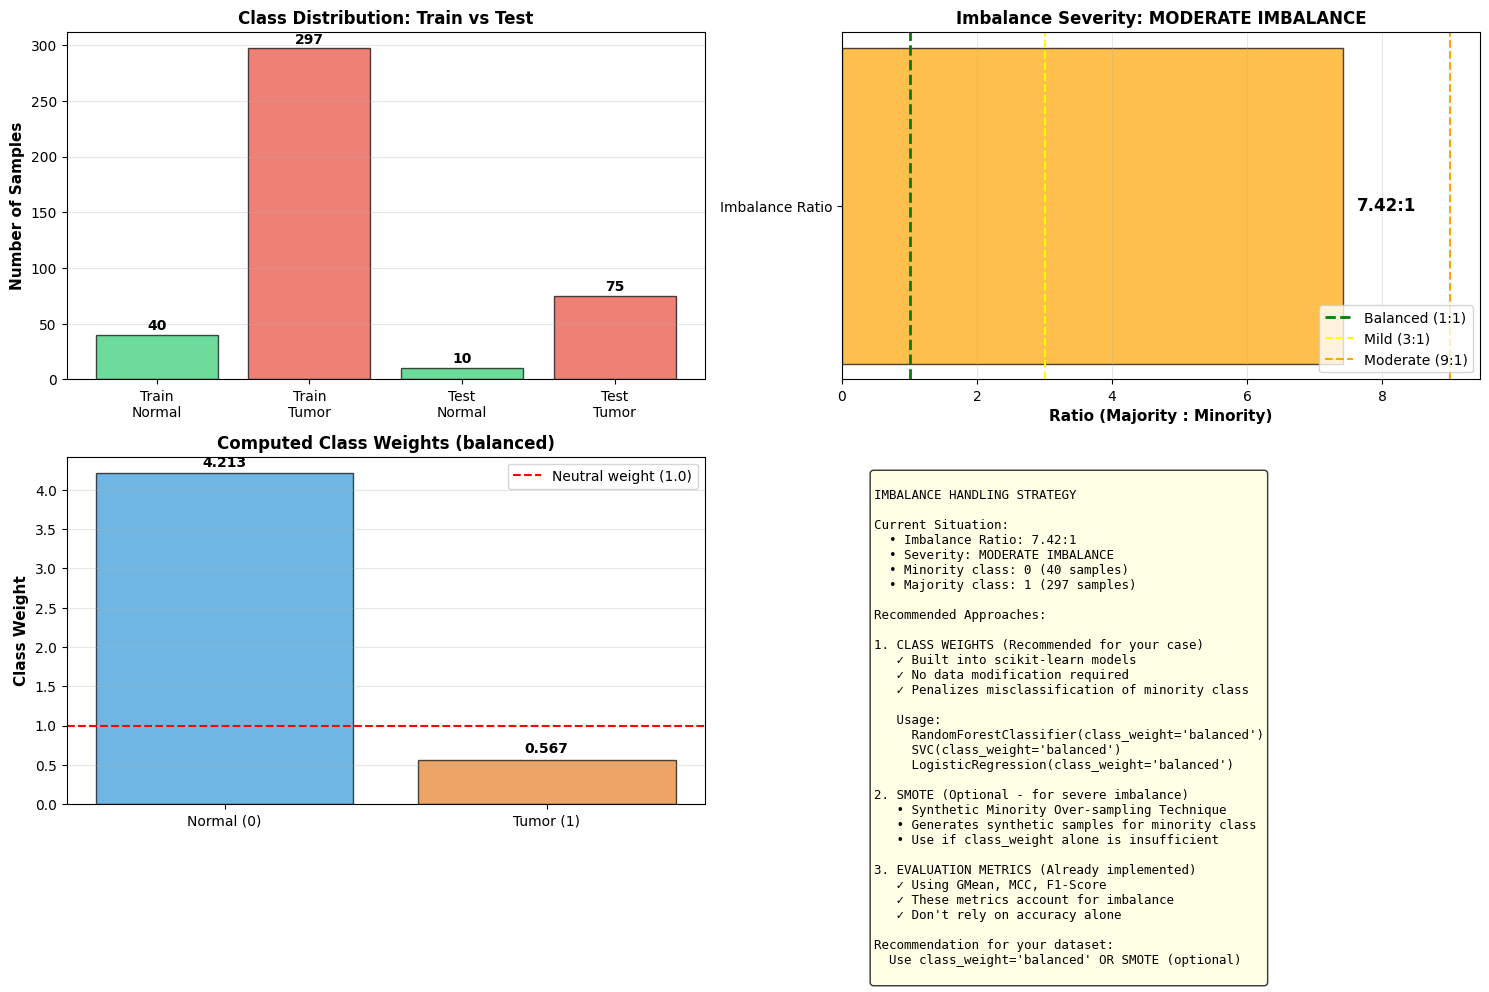


✓ Class imbalance analysis complete
  Analysis saved: /kaggle/working/class_imbalance_analysis.png
  CLASS_WEIGHTS variable created for model training

📋 IMPLEMENTATION GUIDE:
────────────────────────────────────────────────────────────────────────────────
Option 1: Use class_weight (RECOMMENDED - Simple & Effective)
  • Add class_weight='balanced' to your model definitions
  • Works with: RandomForest, SVM, LogisticRegression, XGBoost

Option 2: Use SMOTE (Optional - for more severe imbalance)
  • Run Cell 7E below to apply SMOTE
  • Creates synthetic minority samples
  • Best combined with class_weight
────────────────────────────────────────────────────────────────────────────────


In [18]:
# ============================================================================
# CLASS IMBALANCE ANALYSIS & HANDLING STRATEGY
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

print("="*80)
print("CLASS IMBALANCE ANALYSIS & MITIGATION STRATEGY")
print("="*80)

# -------------------------------------------------------------------------
# Step 1: Analyze current class distribution
# -------------------------------------------------------------------------
train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

total_train = len(y_train)
total_test = len(y_test)

minority_class = min(train_class_counts, key=train_class_counts.get)
majority_class = max(train_class_counts, key=train_class_counts.get)

imbalance_ratio = train_class_counts[majority_class] / train_class_counts[minority_class]

print(f"\nClass Distribution:")
print(f"  Training Set:")
print(f"    Class 0 (Normal): {train_class_counts[0]} ({100*train_class_counts[0]/total_train:.1f}%)")
print(f"    Class 1 (Tumor):  {train_class_counts[1]} ({100*train_class_counts[1]/total_train:.1f}%)")
print(f"  Test Set:")
print(f"    Class 0 (Normal): {test_class_counts[0]} ({100*test_class_counts[0]/total_test:.1f}%)")
print(f"    Class 1 (Tumor):  {test_class_counts[1]} ({100*test_class_counts[1]/total_test:.1f}%)")

print(f"\nImbalance Analysis:")
print(f"  Minority class: {minority_class} ({train_class_counts[minority_class]} samples)")
print(f"  Majority class: {majority_class} ({train_class_counts[majority_class]} samples)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# -------------------------------------------------------------------------
# Step 2: Determine severity and recommend strategy
# -------------------------------------------------------------------------
if imbalance_ratio < 1.5:
    severity = "BALANCED"
    color = "green"
    recommendation = "No special handling needed"
elif imbalance_ratio < 3:
    severity = "MILD IMBALANCE"
    color = "yellow"
    recommendation = "Use class_weight='balanced' in models"
elif imbalance_ratio < 9:
    severity = "MODERATE IMBALANCE"
    color = "orange"
    recommendation = "Use class_weight='balanced' OR SMOTE (optional)"
else:
    severity = "SEVERE IMBALANCE"
    color = "red"
    recommendation = "Strongly recommend SMOTE + class_weight"

print(f"\n{'='*80}")
print(f"IMBALANCE SEVERITY: {severity}")
print(f"RECOMMENDATION: {recommendation}")
print(f"{'='*80}")

# -------------------------------------------------------------------------
# Step 3: Calculate class weights for sklearn models
# -------------------------------------------------------------------------
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"\nComputed Class Weights (for sklearn models):")
print(f"  Class 0 (Normal): {class_weights_dict[0]:.4f}")
print(f"  Class 1 (Tumor):  {class_weights_dict[1]:.4f}")
print(f"  Ratio (Normal/Tumor): {class_weights_dict[0]/class_weights_dict[1]:.2f}:1")

# -------------------------------------------------------------------------
# Step 4: Visualization
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Class distribution comparison
x = ['Train\nNormal', 'Train\nTumor', 'Test\nNormal', 'Test\nTumor']
counts = [train_class_counts[0], train_class_counts[1], 
          test_class_counts[0], test_class_counts[1]]
colors_bars = ['#2ecc71', '#e74c3c', '#2ecc71', '#e74c3c']

bars = axes[0, 0].bar(x, counts, color=colors_bars, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Class Distribution: Train vs Test', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{int(count)}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Imbalance ratio visualization
axes[0, 1].barh(['Imbalance Ratio'], [imbalance_ratio], color=color, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(1, color='green', linestyle='--', linewidth=2, label='Balanced (1:1)')
axes[0, 1].axvline(3, color='yellow', linestyle='--', linewidth=1.5, label='Mild (3:1)')
axes[0, 1].axvline(9, color='orange', linestyle='--', linewidth=1.5, label='Moderate (9:1)')
axes[0, 1].set_xlabel('Ratio (Majority : Minority)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Imbalance Severity: {severity}', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].text(imbalance_ratio + 0.2, 0, f'{imbalance_ratio:.2f}:1', 
               va='center', fontweight='bold', fontsize=12)

# Plot 3: Class weights
classes = ['Normal (0)', 'Tumor (1)']
weights = [class_weights_dict[0], class_weights_dict[1]]
bars = axes[1, 0].bar(classes, weights, color=['#3498db', '#e67e22'], alpha=0.7, edgecolor='black')
axes[1, 0].axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='Neutral weight (1.0)')
axes[1, 0].set_ylabel('Class Weight', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Computed Class Weights (balanced)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

for bar, weight in zip(bars, weights):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                   f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Strategy recommendation summary
strategy_text = f"""
IMBALANCE HANDLING STRATEGY

Current Situation:
  • Imbalance Ratio: {imbalance_ratio:.2f}:1
  • Severity: {severity}
  • Minority class: {minority_class} ({train_class_counts[minority_class]} samples)
  • Majority class: {majority_class} ({train_class_counts[majority_class]} samples)

Recommended Approaches:

1. CLASS WEIGHTS (Recommended for your case)
   ✓ Built into scikit-learn models
   ✓ No data modification required
   ✓ Penalizes misclassification of minority class
   
   Usage:
     RandomForestClassifier(class_weight='balanced')
     SVC(class_weight='balanced')
     LogisticRegression(class_weight='balanced')

2. SMOTE (Optional - for severe imbalance)
   • Synthetic Minority Over-sampling Technique
   • Generates synthetic samples for minority class
   • Use if class_weight alone is insufficient
   
3. EVALUATION METRICS (Already implemented)
   ✓ Using GMean, MCC, F1-Score
   ✓ These metrics account for imbalance
   ✓ Don't rely on accuracy alone

Recommendation for your dataset:
  {recommendation}
"""

axes[1, 1].text(0.05, 0.95, strategy_text, transform=axes[1, 1].transAxes,
               fontsize=9, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/class_imbalance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------------
# Step 5: Set global configuration for imbalance handling
# -------------------------------------------------------------------------
# Save class weights for later use
CLASS_WEIGHTS = class_weights_dict
IMBALANCE_RATIO = imbalance_ratio

print("\n" + "="*80)
print("✓ Class imbalance analysis complete")
print("  Analysis saved: /kaggle/working/class_imbalance_analysis.png")
print(f"  CLASS_WEIGHTS variable created for model training")
print("="*80)

print("\n📋 IMPLEMENTATION GUIDE:")
print("─"*80)
print("Option 1: Use class_weight (RECOMMENDED - Simple & Effective)")
print("  • Add class_weight='balanced' to your model definitions")
print("  • Works with: RandomForest, SVM, LogisticRegression, XGBoost")
print("")
print("Option 2: Use SMOTE (Optional - for more severe imbalance)")
print("  • Run Cell 7E below to apply SMOTE")
print("  • Creates synthetic minority samples")
print("  • Best combined with class_weight")
print("─"*80)


Evaluation function for imbalanced data

In [19]:
def evaluate_model(y_true, y_pred, y_proba=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = accuracy_score(y_true, y_pred)
    sen = tp / (tp + fn) if (tp + fn) else 0.0
    spe = tn / (tn + fp) if (tn + fp) else 0.0
    gmn = np.sqrt(max(sen,0)*max(spe,0))
    mcc = matthews_corrcoef(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    out = {"Accuracy": acc, "Sensitivity": sen, "Specificity": spe, "GMean": gmn, "MCC": mcc, "F1": f1}
    if y_proba is not None:
        try:
            out["AUC"] = roc_auc_score(y_true, y_proba)
        except Exception:
            out["AUC"] = np.nan
    return out


Decision Tree

In [20]:
print("=" * 60)
print("TRAINING DECISION TREE MODEL (with class_weight)")
print("=" * 60)

# Use resampled data if SMOTE was applied, otherwise use original
X_train_final = Xsel_train_resampled if 'Xsel_train_resampled' in locals() else Xsel_train
y_train_final = y_train_resampled if 'y_train_resampled' in locals() else y_train

if DO_TUNING:
    from scipy.stats import randint
    dt_param = {
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "criterion": ["gini", "entropy"]
    }
    dt_cv = RandomizedSearchCV(
        DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'  # ✅ ADDED
        ),
        dt_param, n_iter=200, cv=10, scoring="f1", 
        n_jobs=-1, random_state=RANDOM_STATE, verbose=1
    )
    dt_cv.fit(X_train_final, y_train_final)
    dt = dt_cv.best_estimator_
else:
    print("Else In Use")
    dt = DecisionTreeClassifier(
        max_depth=15, 
        random_state=RANDOM_STATE,
        class_weight='balanced'  # ✅ ADDED
    )

dt.fit(X_train_final, y_train_final)
dt_pred = dt.predict(Xsel_test)
dt_metrics = evaluate_model(y_test, dt_pred)

print(f"\n✓ Decision Tree Results:")
for metric, value in dt_metrics.items():
    print(f"  {metric}: {value:.4f}")


TRAINING DECISION TREE MODEL (with class_weight)
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

✓ Decision Tree Results:
  Accuracy: 0.9647
  Sensitivity: 0.9600
  Specificity: 1.0000
  GMean: 0.9798
  MCC: 0.8593
  F1: 0.9796


Random Forest

In [21]:
print("=" * 60)
print("TRAINING RANDOM FOREST MODEL (with class_weight)")
print("=" * 60)

if DO_TUNING:
    from scipy.stats import randint
    rf_param = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(5, 30),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None]
    }
    rf_cv = RandomizedSearchCV(
        RandomForestClassifier(
            random_state=RANDOM_STATE, 
            n_jobs=-1,
            class_weight='balanced'  # ✅ ADDED
        ),
        rf_param, n_iter=200, cv=10, scoring="f1", 
        n_jobs=-1, random_state=RANDOM_STATE, verbose=1
    )
    rf_cv.fit(X_train_final, y_train_final)
    rf = rf_cv.best_estimator_
else:
    rf = RandomForestClassifier(
        n_estimators=300, max_depth=15, min_samples_split=2, 
        min_samples_leaf=1, max_features="sqrt", 
        random_state=RANDOM_STATE, n_jobs=-1,
        class_weight='balanced'  # ✅ ADDED
    )

rf.fit(X_train_final, y_train_final)
rf_pred = rf.predict(Xsel_test)
rf_proba = rf.predict_proba(Xsel_test)[:, 1]
rf_metrics = evaluate_model(y_test, rf_pred, rf_proba)

print(f"\n✓ Random Forest Results:")
for metric, value in rf_metrics.items():
    print(f"  {metric}: {value:.4f}")


TRAINING RANDOM FOREST MODEL (with class_weight)
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

✓ Random Forest Results:
  Accuracy: 0.9882
  Sensitivity: 0.9867
  Specificity: 1.0000
  GMean: 0.9933
  MCC: 0.9471
  F1: 0.9933
  AUC: 1.0000


XGBoost

In [22]:
# ============================================================================
# TRAINING XGBoost MODEL (Manual CV - No sklearn RandomizedSearchCV)
# ============================================================================

print("=" * 60)
print("TRAINING XGBoost MODEL (with scale_pos_weight)")
print("=" * 60)

# Use resampled data if SMOTE was applied
X_train_final = Xsel_train_resampled if 'Xsel_train_resampled' in locals() else Xsel_train
y_train_final = y_train_resampled if 'y_train_resampled' in locals() else y_train

# Calculate scale_pos_weight
scale_pos_weight = np.sum(y_train_final == 0) / np.sum(y_train_final == 1)

print(f"\nClass imbalance handling:")
print(f"  Normal samples: {np.sum(y_train_final == 0)}")
print(f"  Tumor samples: {np.sum(y_train_final == 1)}")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")

if DO_TUNING:
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score
    import random
    
    print("\n🔍 Starting manual hyperparameter search...")
    print("   Testing 50 random hyperparameter combinations with 5-fold CV")
    print("   This may take 10-15 minutes...")
    
    # Define parameter distributions
    param_grid = {
        "n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500],
        "max_depth": [3, 4, 5, 6, 7, 8, 9],
        "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3],
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "gamma": [0, 0.5, 1, 1.5, 2, 3, 4, 5],
        "min_child_weight": [1, 2, 3, 4, 5, 7, 10]
    }
    
    # Random search: test 50 combinations
    random.seed(RANDOM_STATE)
    n_iter = 50
    best_f1 = 0
    best_params = None
    
    # Initialize CV splitter
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    for iteration in range(n_iter):
        # Sample random parameters
        params = {
            'n_estimators': random.choice(param_grid['n_estimators']),
            'max_depth': random.choice(param_grid['max_depth']),
            'learning_rate': random.choice(param_grid['learning_rate']),
            'subsample': random.choice(param_grid['subsample']),
            'colsample_bytree': random.choice(param_grid['colsample_bytree']),
            'gamma': random.choice(param_grid['gamma']),
            'min_child_weight': random.choice(param_grid['min_child_weight'])
        }
        
        # Cross-validation
        cv_f1_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_final, y_train_final)):
            # Split data
            if isinstance(X_train_final, np.ndarray):
                X_tr, X_val = X_train_final[train_idx], X_train_final[val_idx]
            else:
                X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
            
            y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]
            
            # Train model
            model = xgb.XGBClassifier(
                **params,
                scale_pos_weight=scale_pos_weight,
                random_state=RANDOM_STATE,
                eval_metric="logloss",
                tree_method="hist",
                n_jobs=-1,
                use_label_encoder=False
            )
            
            model.fit(X_tr, y_tr, verbose=False)
            
            # Predict and evaluate
            val_pred = model.predict(X_val)
            fold_f1 = f1_score(y_val, val_pred)
            cv_f1_scores.append(fold_f1)
        
        # Average F1 across folds
        mean_f1 = np.mean(cv_f1_scores)
        std_f1 = np.std(cv_f1_scores)
        
        # Update best
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = params.copy()
        
        # Progress update
        if (iteration + 1) % 10 == 0:
            print(f"   [{iteration+1}/{n_iter}] Best CV F1: {best_f1:.4f} | Current: {mean_f1:.4f} ± {std_f1:.4f}")
    
    print(f"\n✓ Hyperparameter search complete!")
    print(f"  Best mean CV F1: {best_f1:.4f}")
    print(f"  Best parameters:")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # Train final model with best parameters
    print("\n   Training final XGBoost model with best parameters...")
    xgb_clf = xgb.XGBClassifier(
        **best_params,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        tree_method="hist",
        n_jobs=-1,
        use_label_encoder=False
    )

else:
    # Use default parameters (no tuning)
    print("\n🚀 Using default hyperparameters...")
    
    xgb_clf = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        min_child_weight=1,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        tree_method="hist",
        n_jobs=-1,
        use_label_encoder=False
    )
    
    print(f"\n  Parameters:")
    print(f"    n_estimators: 300")
    print(f"    max_depth: 6")
    print(f"    learning_rate: 0.1")
    print(f"    subsample: 0.8")
    print(f"    colsample_bytree: 0.8")
    print(f"    scale_pos_weight: {scale_pos_weight:.2f}")

# -------------------------------------------------------------------------
# Train on full training set
# -------------------------------------------------------------------------
print("\n   Fitting XGBoost on full training set...")
xgb_clf.fit(X_train_final, y_train_final, verbose=False)

# -------------------------------------------------------------------------
# Make predictions
# -------------------------------------------------------------------------
print("\n📈 Making predictions on test set...")
xgb_pred = xgb_clf.predict(Xsel_test)
xgb_proba = xgb_clf.predict_proba(Xsel_test)[:, 1]

# Evaluate
xgb_metrics = evaluate_model(y_test, xgb_pred, xgb_proba)

# -------------------------------------------------------------------------
# Display results
# -------------------------------------------------------------------------
print("\n" + "=" * 60)
print(f"XGBoost RESULTS (scale_pos_weight={scale_pos_weight:.2f})")
print("=" * 60)
for metric, value in xgb_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Display feature importance (top 15)
feature_importance = xgb_clf.feature_importances_
top_features_idx = np.argsort(feature_importance)[-15:][::-1]

print(f"\nTop 15 Most Important Features:")
print(f"{'Rank':<6} {'Feature':<45} {'Importance':<12}")
print("-" * 65)
for rank, idx in enumerate(top_features_idx, 1):
    if idx < len(sel_names):
        feature_name = sel_names[idx][:43]
    else:
        feature_name = f"Feature_{idx}"
    print(f"{rank:<6} {feature_name:<45} {feature_importance[idx]:.6f}")

print("\n✓ XGBoost training complete")


TRAINING XGBoost MODEL (with scale_pos_weight)

Class imbalance handling:
  Normal samples: 40
  Tumor samples: 297
  scale_pos_weight: 0.13

🔍 Starting manual hyperparameter search...
   Testing 50 random hyperparameter combinations with 5-fold CV
   This may take 10-15 minutes...
   [10/50] Best CV F1: 0.9900 | Current: 0.9900 ± 0.0096
   [20/50] Best CV F1: 0.9916 | Current: 0.9846 ± 0.0067
   [30/50] Best CV F1: 0.9916 | Current: 0.9810 ± 0.0104
   [40/50] Best CV F1: 0.9932 | Current: 0.9932 ± 0.0064
   [50/50] Best CV F1: 0.9933 | Current: 0.9883 ± 0.0084

✓ Hyperparameter search complete!
  Best mean CV F1: 0.9933
  Best parameters:
    n_estimators: 350
    max_depth: 3
    learning_rate: 0.01
    subsample: 0.9
    colsample_bytree: 0.8
    gamma: 1
    min_child_weight: 1

   Training final XGBoost model with best parameters...

   Fitting XGBoost on full training set...

📈 Making predictions on test set...

XGBoost RESULTS (scale_pos_weight=0.13)
  Accuracy: 0.9765
  Sensiti

SVM

In [23]:
print("=" * 60)
print("TRAINING SUPPORT VECTOR MACHINE (with class_weight)")
print("=" * 60)

if DO_TUNING:
    from scipy.stats import uniform, randint
    svm_param = {
        "C": uniform(0.1, 100),
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"],
        "degree": randint(2, 5)
    }
    svm_cv = RandomizedSearchCV(
        SVC(
            probability=True, 
            random_state=RANDOM_STATE,
            class_weight='balanced'  # ✅ ADDED
        ),
        svm_param, n_iter=200, cv=10, scoring="f1", 
        n_jobs=-1, random_state=RANDOM_STATE, verbose=1
    )
    svm_cv.fit(X_train_final, y_train_final)
    svm = svm_cv.best_estimator_
else:
    svm = SVC(
        kernel="rbf", C=10, gamma="scale", 
        probability=True, random_state=RANDOM_STATE,
        class_weight='balanced'  # ✅ ADDED
    )

svm.fit(X_train_final, y_train_final)
svm_pred = svm.predict(Xsel_test)
svm_proba = svm.predict_proba(Xsel_test)[:, 1]
svm_metrics = evaluate_model(y_test, svm_pred, svm_proba)

print(f"\n✓ SVM Results:")
for metric, value in svm_metrics.items():
    print(f"  {metric}: {value:.4f}")


TRAINING SUPPORT VECTOR MACHINE (with class_weight)
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

✓ SVM Results:
  Accuracy: 0.9882
  Sensitivity: 0.9867
  Specificity: 1.0000
  GMean: 0.9933
  MCC: 0.9471
  F1: 0.9933
  AUC: 1.0000


Neural network

TRAINING NEURAL NETWORK MODEL

Hyperparameter Search Space:
  Number of layers: [1, 2, 3]
  Nodes per layer: 2 to input_size (2000)
  Dropout rate: 0.1-0.3
  Activation functions: ['relu', 'elu', 'gelu', 'swish']
  Optimizer: adadelta
  Learning rate: 1.0

🔍 Starting hyperparameter tuning...
   This may take 30-60 minutes depending on search space size
   Testing 50 hyperparameter combinations...


2025-11-05 16:00:13.490958: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


   Completed 10/50 combinations. Best F1: 0.9916
   Completed 20/50 combinations. Best F1: 0.9916
   Completed 30/50 combinations. Best F1: 0.9916
   Completed 40/50 combinations. Best F1: 0.9916
   Completed 50/50 combinations. Best F1: 0.9916

✓ Hyperparameter tuning complete!
  Best validation F1: 0.9916
  Best parameters: {'activation': 'relu', 'dropout_rate': 0.25, 'learning_rate': 1.0, 'nodes_per_layer_factor': 512, 'num_layers': 1, 'optimizer': 'adadelta', 'nodes_per_layer': 512}

📈 Making predictions on test set...

NEURAL NETWORK RESULTS
  Accuracy: 0.9765
  Sensitivity: 0.9867
  Specificity: 0.9000
  GMean: 0.9423
  MCC: 0.8867
  F1: 0.9867
  AUC: 0.9880


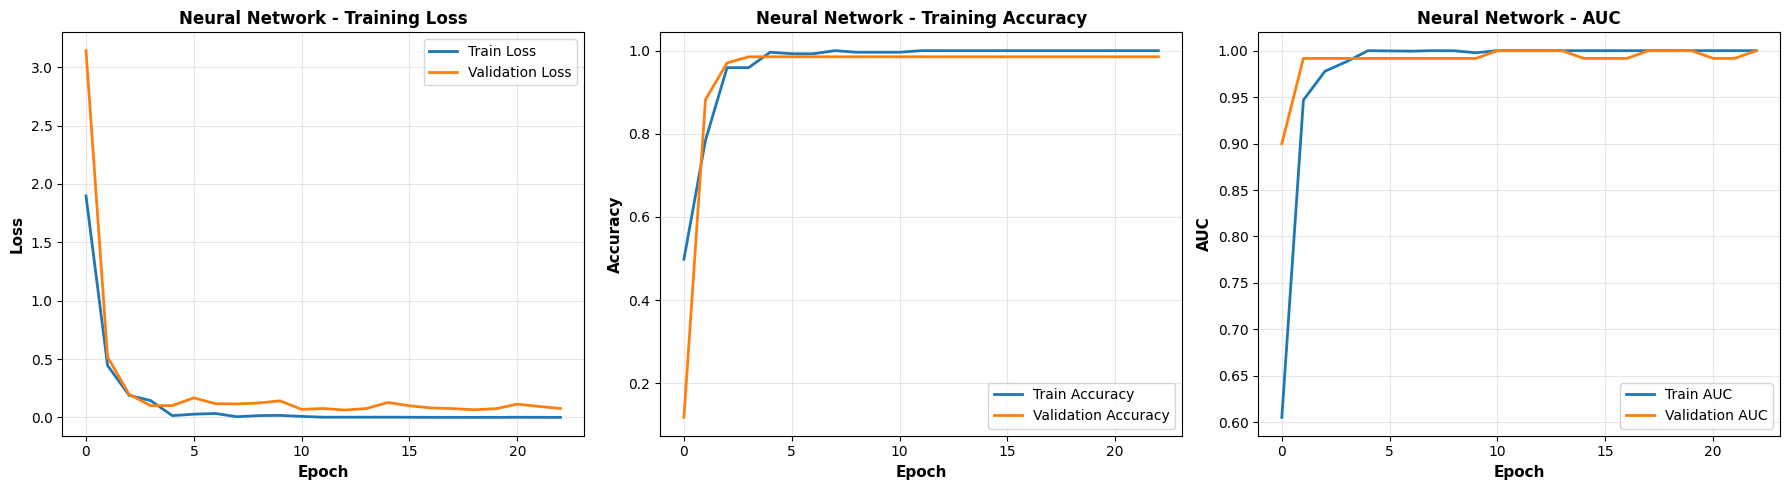


✓ Neural Network training complete
  Training history saved: /kaggle/working/nn_training_history.png


In [24]:
# ============================================================================
# NEURAL NETWORK WITH HYPERPARAMETER TUNING (Paper specifications)
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd

print("=" * 80)
print("TRAINING NEURAL NETWORK MODEL")
print("=" * 80)

# Use resampled data if SMOTE was applied, otherwise use original
X_train_final = Xsel_train_resampled if 'Xsel_train_resampled' in locals() else Xsel_train
y_train_final = y_train_resampled if 'y_train_resampled' in locals() else y_train

# -------------------------------------------------------------------------
# Hyperparameter Grid from Paper (Table 2)
# -------------------------------------------------------------------------
nn_hyperparam_grid = {
    'num_layers': [1, 2, 3],
    'nodes_per_layer_factor': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],  # Multiples of input size
    'dropout_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
    'activation': ['relu', 'elu', 'gelu', 'swish'],
    'learning_rate': [1.00],  # Paper uses fixed learning rate = 1
    'optimizer': ['adadelta']  # Paper uses Adadelta
}

print(f"\nHyperparameter Search Space:")
print(f"  Number of layers: {nn_hyperparam_grid['num_layers']}")
print(f"  Nodes per layer: 2 to input_size ({X_train_final.shape[1]})")
print(f"  Dropout rate: {min(nn_hyperparam_grid['dropout_rate'])}-{max(nn_hyperparam_grid['dropout_rate'])}")
print(f"  Activation functions: {nn_hyperparam_grid['activation']}")
print(f"  Optimizer: {nn_hyperparam_grid['optimizer'][0]}")
print(f"  Learning rate: {nn_hyperparam_grid['learning_rate'][0]}")

# -------------------------------------------------------------------------
# Function to build Neural Network
# -------------------------------------------------------------------------
def build_nn_model(input_dim, num_layers=2, nodes_per_layer=128, 
                   dropout_rate=0.2, activation='relu', 
                   learning_rate=1.0, optimizer_name='adadelta'):
    """
    Build neural network according to paper's architecture.
    
    Parameters from Table 2:
    - num_layers: 1, 2, or 3
    - nodes_per_layer: 2 to input_size
    - dropout_rate: 0.1 to 0.3
    - activation: relu, elu, gelu, swish
    - learning_rate: 1 (fixed)
    - optimizer: Adadelta
    """
    
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    # Add hidden layers
    for layer_idx in range(num_layers):
        model.add(layers.Dense(nodes_per_layer, activation=activation,
                              kernel_initializer='he_normal'))
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile with specified optimizer
    if optimizer_name == 'adadelta':
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    # Calculate class weights for imbalanced data
    neg_samples = np.sum(y_train_final == 0)
    pos_samples = np.sum(y_train_final == 1)
    total = len(y_train_final)
    
    weight_for_0 = (1 / neg_samples) * (total / 2.0)
    weight_for_1 = (1 / pos_samples) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model, class_weight

# -------------------------------------------------------------------------
# Option 1: FULL HYPERPARAMETER TUNING (Slow but thorough)
# -------------------------------------------------------------------------
if DO_TUNING:
    print("\n🔍 Starting hyperparameter tuning...")
    print(f"   This may take 30-60 minutes depending on search space size")
    
    # Random search: sample 50 combinations
    from itertools import islice
    import random
    
    all_combinations = list(ParameterGrid(nn_hyperparam_grid))
    random.seed(RANDOM_STATE)
    sampled_combinations = random.sample(all_combinations, min(50, len(all_combinations)))
    
    print(f"   Testing {len(sampled_combinations)} hyperparameter combinations...")
    
    best_f1 = 0
    best_params = None
    best_model = None
    
    for idx, params in enumerate(sampled_combinations, 1):
        # Calculate nodes per layer based on input size
        nodes = min(params['nodes_per_layer_factor'], X_train_final.shape[1])
        
        # Build model
        model, class_weight = build_nn_model(
            input_dim=X_train_final.shape[1],
            num_layers=params['num_layers'],
            nodes_per_layer=nodes,
            dropout_rate=params['dropout_rate'],
            activation=params['activation'],
            learning_rate=params['learning_rate'],
            optimizer_name=params['optimizer']
        )
        
        # Early stopping callback
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train_final, y_train_final,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            class_weight=class_weight,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Evaluate on validation set
        val_pred_proba = model.predict(X_train_final[int(0.8*len(X_train_final)):], verbose=0)
        val_pred = (val_pred_proba > 0.5).astype(int).flatten()
        val_y = y_train_final.iloc[int(0.8*len(y_train_final)):]
        
        from sklearn.metrics import f1_score
        val_f1 = f1_score(val_y, val_pred)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_params = params.copy()
            best_params['nodes_per_layer'] = nodes
            best_model = model
        
        if idx % 10 == 0:
            print(f"   Completed {idx}/{len(sampled_combinations)} combinations. Best F1: {best_f1:.4f}")
    
    print(f"\n✓ Hyperparameter tuning complete!")
    print(f"  Best validation F1: {best_f1:.4f}")
    print(f"  Best parameters: {best_params}")
    
    nn = best_model

# -------------------------------------------------------------------------
# Option 2: USE OPTIMIZED DEFAULTS (Fast, based on common good values)
# -------------------------------------------------------------------------
else:
    print("\n🚀 Using optimized default hyperparameters...")
    
    # Good defaults based on paper's recommendations
    num_layers = 3
    nodes_per_layer = min(128, X_train_final.shape[1])
    dropout_rate = 0.3
    activation = 'relu'
    learning_rate = 1.0
    optimizer_name = 'adadelta'
    
    print(f"\n  Architecture:")
    print(f"    Layers: {num_layers}")
    print(f"    Nodes per layer: {nodes_per_layer}")
    print(f"    Dropout: {dropout_rate}")
    print(f"    Activation: {activation}")
    print(f"    Optimizer: {optimizer_name}")
    print(f"    Learning rate: {learning_rate}")
    
    # Build model
    nn, class_weight = build_nn_model(
        input_dim=X_train_final.shape[1],
        num_layers=num_layers,
        nodes_per_layer=nodes_per_layer,
        dropout_rate=dropout_rate,
        activation=activation,
        learning_rate=learning_rate,
        optimizer_name=optimizer_name
    )
    
    print("\n📊 Model Architecture:")
    nn.summary()
    
    # Callbacks for training
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    
    # Train model
    print("\n🏋️ Training Neural Network...")
    history = nn.fit(
        X_train_final, y_train_final,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

# -------------------------------------------------------------------------
# Make predictions on test set
# -------------------------------------------------------------------------
print("\n📈 Making predictions on test set...")
nn_pred_proba = nn.predict(Xsel_test, verbose=0).flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)

# Evaluate
nn_metrics = evaluate_model(y_test, nn_pred, nn_pred_proba)

print("\n" + "=" * 80)
print("NEURAL NETWORK RESULTS")
print("=" * 80)
for metric, value in nn_metrics.items():
    print(f"  {metric}: {value:.4f}")

# -------------------------------------------------------------------------
# Plot training history
# -------------------------------------------------------------------------
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[0].set_title('Neural Network - Training Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1].set_title('Neural Network - Training Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
if 'auc' in history.history:
    axes[2].plot(history.history['auc'], label='Train AUC', linewidth=2)
    axes[2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('AUC', fontsize=11, fontweight='bold')
    axes[2].set_title('Neural Network - AUC', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/nn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Neural Network training complete")
print("  Training history saved: /kaggle/working/nn_training_history.png")


Consolidate metrics and view comparison

In [25]:
import pandas as pd

results_df = pd.DataFrame([
    {"Model":"Decision Tree", **dt_metrics},
    {"Model":"Random Forest", **rf_metrics},
    {"Model":"XGBoost", **xgb_metrics},
    {"Model":"SVM", **svm_metrics},
    {"Model":"Neural Net", **nn_metrics},
]).set_index("Model").round(4)

results_df


,Accuracy,Sensitivity,Specificity,GMean,MCC,F1,AUC
Model,,,,,,,
Decision Tree,0.9647,0.9600,1.0,0.9798,0.8593,0.9796,NaN
Random Forest,0.9882,0.9867,1.0,0.9933,0.9471,0.9933,1.0000
XGBoost,0.9765,0.9733,1.0,0.9866,0.9006,0.9865,0.9973
SVM,0.9882,0.9867,1.0,0.9933,0.9471,0.9933,1.0000
Neural Net,0.9765,0.9867,0.9,0.9423,0.8867,0.9867,0.9880


GENERATING CONFUSION MATRICES FOR ALL MODELS


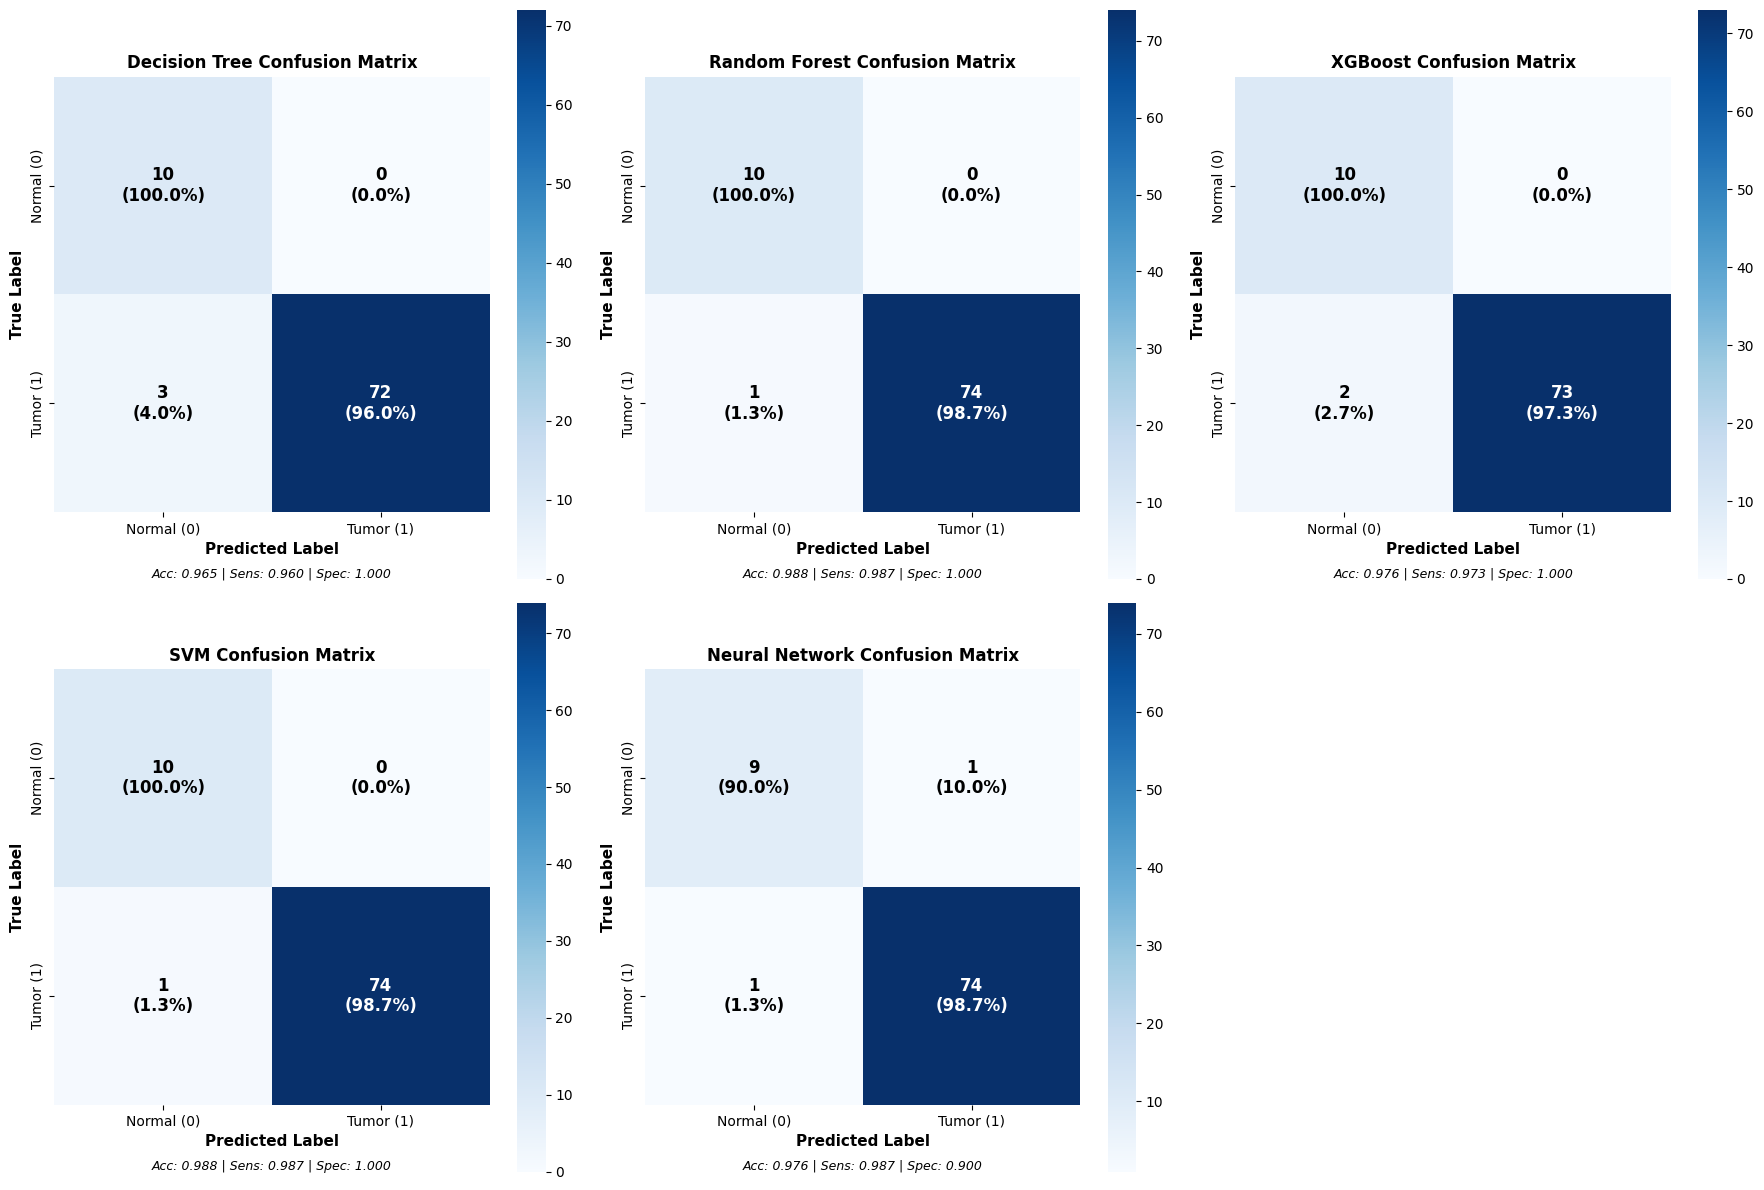


CONFUSION MATRIX DETAILED STATISTICS

Decision Tree:
────────────────────────────────────────────────────────────────────────────────
  Confusion Matrix:
                    Predicted Normal  Predicted Tumor
    Actual Normal         10 (TN)            0 (FP)
    Actual Tumor           3 (FN)           72 (TP)

  Classification Metrics:
    Accuracy:              0.9647  (82/85)
    Sensitivity (Recall):  0.9600  (TP rate for Tumor)
    Specificity:           1.0000  (TN rate for Normal)
    Precision (PPV):       1.0000  (Positive Predictive Value)
    NPV:                   0.7692  (Negative Predictive Value)

  Error Rates:
    False Positive Rate:   0.0000  (Normal predicted as Tumor)
    False Negative Rate:   0.0400  (Tumor predicted as Normal)
    Misclassification:     3/85 samples (3.53%)

Random Forest:
────────────────────────────────────────────────────────────────────────────────
  Confusion Matrix:
                    Predicted Normal  Predicted Tumor
    Actual Normal  

In [26]:
# ============================================================================
# CONFUSION MATRIX VISUALIZATION FOR ALL MODELS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

print("="*80)
print("GENERATING CONFUSION MATRICES FOR ALL MODELS")
print("="*80)

# -------------------------------------------------------------------------
# Step 1: Collect all model predictions
# -------------------------------------------------------------------------
models_predictions = {
    'Decision Tree': dt_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'SVM': svm_pred,
    'Neural Network': nn_pred
}

# -------------------------------------------------------------------------
# Step 2: Create confusion matrices
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, predictions) in enumerate(models_predictions.items()):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Extract values
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate percentages
    total = cm.sum()
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    ax = axes[idx]
    
    # Use seaborn heatmap for better visualization
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                cbar=True, square=True, ax=ax,
                xticklabels=['Normal (0)', 'Tumor (1)'],
                yticklabels=['Normal (0)', 'Tumor (1)'])
    
    # Add custom annotations with both counts and percentages
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            percent = cm_percent[i, j]
            
            # Choose text color based on background
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            
            # Add text with count and percentage
            ax.text(j + 0.5, i + 0.5, 
                   f'{count}\n({percent:.1f}%)',
                   ha='center', va='center',
                   fontsize=12, fontweight='bold',
                   color=text_color)
    
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name} Confusion Matrix', fontsize=12, fontweight='bold')
    
    # Add performance metrics as subtitle
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / total
    
    subtitle = f'Acc: {accuracy:.3f} | Sens: {sensitivity:.3f} | Spec: {specificity:.3f}'
    ax.text(0.5, -0.15, subtitle, transform=ax.transAxes,
           ha='center', fontsize=9, style='italic')

# Remove the 6th subplot (we only have 5 models)
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------------
# Step 3: Print detailed confusion matrix statistics
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("CONFUSION MATRIX DETAILED STATISTICS")
print("="*80)

for model_name, predictions in models_predictions.items():
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    total = cm.sum()
    
    # Calculate metrics
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for negative class
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # False rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    
    print(f"\n{model_name}:")
    print(f"{'─'*80}")
    print(f"  Confusion Matrix:")
    print(f"                    Predicted Normal  Predicted Tumor")
    print(f"    Actual Normal   {tn:8d} (TN)     {fp:8d} (FP)")
    print(f"    Actual Tumor    {fn:8d} (FN)     {tp:8d} (TP)")
    print(f"\n  Classification Metrics:")
    print(f"    Accuracy:              {accuracy:.4f}  ({tp+tn}/{total})")
    print(f"    Sensitivity (Recall):  {sensitivity:.4f}  (TP rate for Tumor)")
    print(f"    Specificity:           {specificity:.4f}  (TN rate for Normal)")
    print(f"    Precision (PPV):       {precision:.4f}  (Positive Predictive Value)")
    print(f"    NPV:                   {npv:.4f}  (Negative Predictive Value)")
    print(f"\n  Error Rates:")
    print(f"    False Positive Rate:   {fpr:.4f}  (Normal predicted as Tumor)")
    print(f"    False Negative Rate:   {fnr:.4f}  (Tumor predicted as Normal)")
    print(f"    Misclassification:     {fp+fn}/{total} samples ({100*(fp+fn)/total:.2f}%)")

# -------------------------------------------------------------------------
# Step 4: Create comparison summary table
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("CONFUSION MATRIX COMPARISON TABLE")
print("="*80)

comparison_data = []
for model_name, predictions in models_predictions.items():
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    comparison_data.append({
        'Model': model_name,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'Total Correct': tp + tn,
        'Total Wrong': fp + fn
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('/kaggle/working/confusion_matrix_comparison.csv', index=False)

print("\n" + "="*80)
print("✓ Confusion matrices generated successfully")
print("  Files saved:")
print("    - /kaggle/working/confusion_matrices_all_models.png")
print("    - /kaggle/working/confusion_matrix_comparison.csv")
print("="*80)


GENERATING NORMALIZED CONFUSION MATRICES


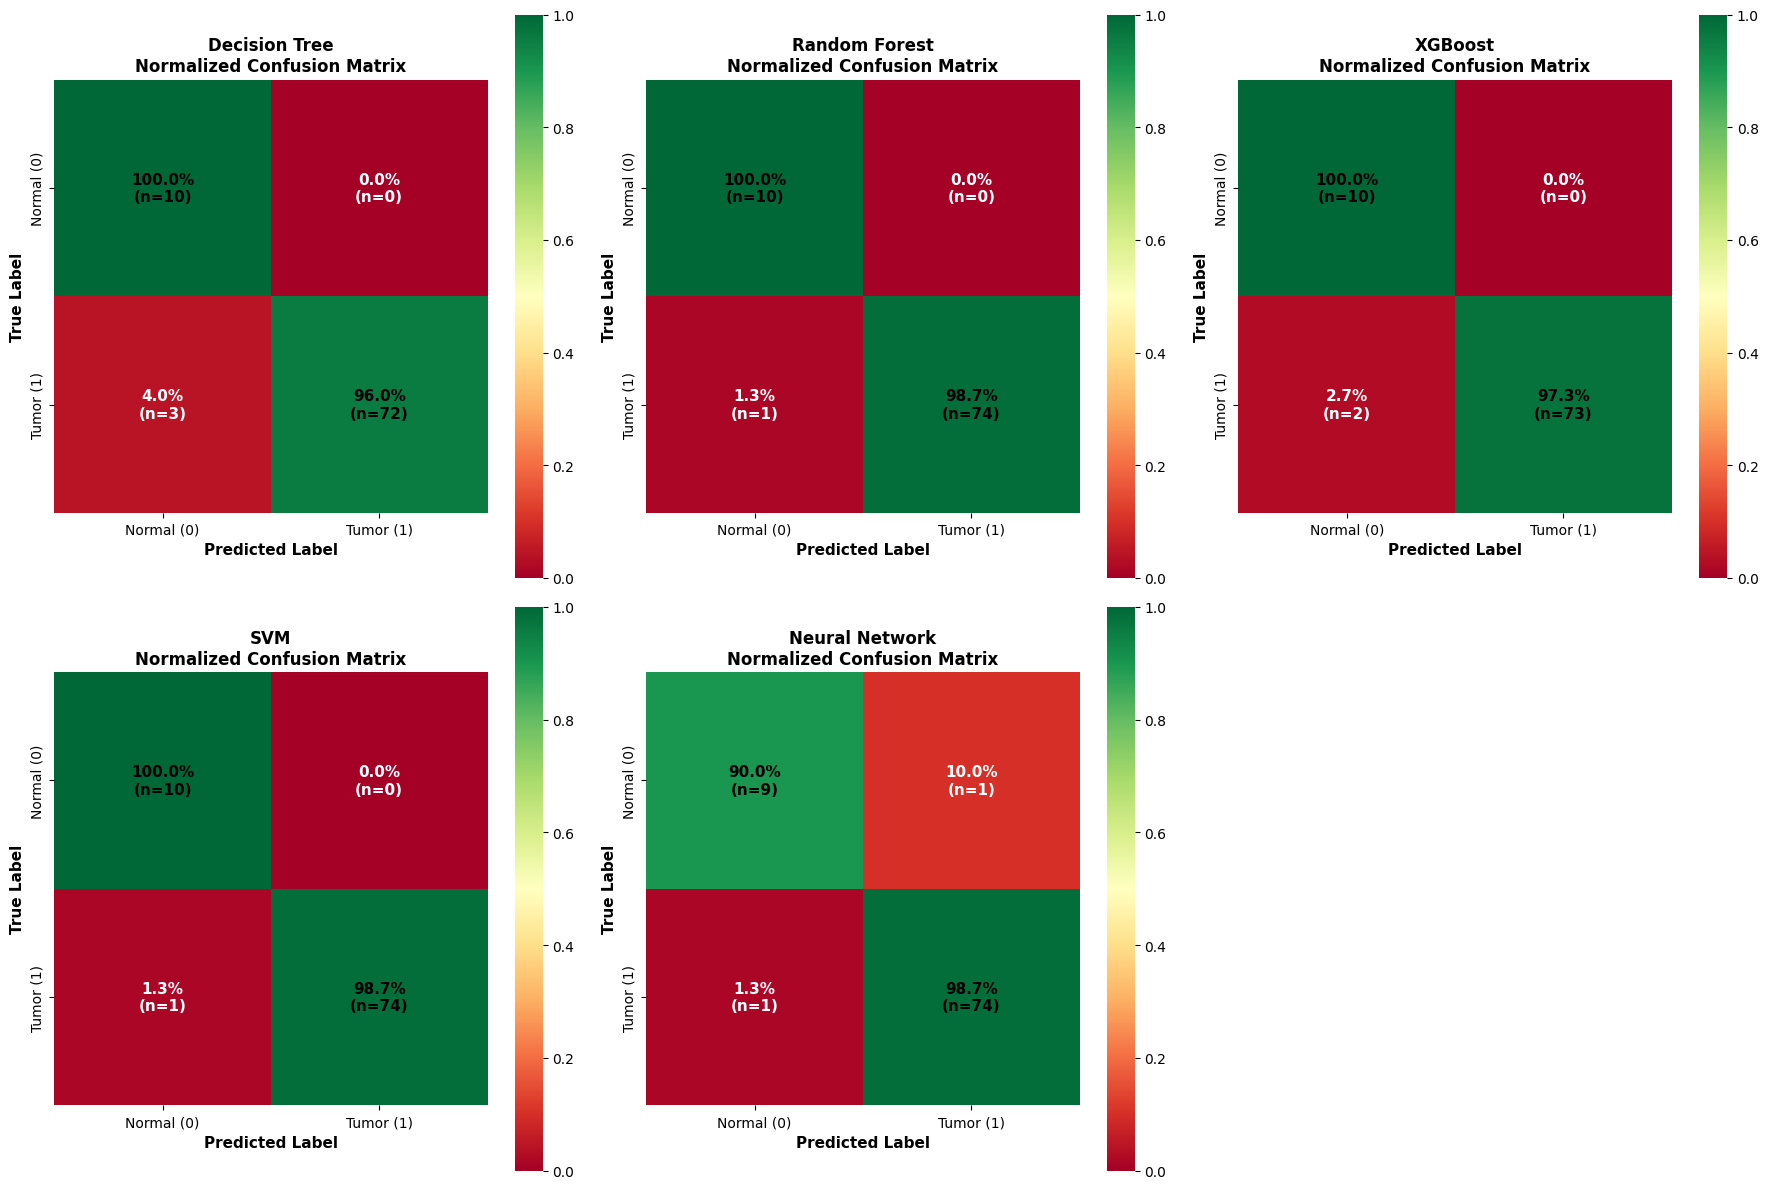


✓ Normalized confusion matrices saved:
  /kaggle/working/confusion_matrices_normalized.png


In [27]:
# ============================================================================
# NORMALIZED CONFUSION MATRICES (Row-wise percentages)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

print("="*80)
print("GENERATING NORMALIZED CONFUSION MATRICES")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, predictions) in enumerate(models_predictions.items()):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Normalize by row (true label)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    ax = axes[idx]
    
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='RdYlGn', 
                cbar=True, square=True, ax=ax, vmin=0, vmax=1,
                xticklabels=['Normal (0)', 'Tumor (1)'],
                yticklabels=['Normal (0)', 'Tumor (1)'])
    
    # Add custom annotations
    for i in range(2):
        for j in range(2):
            percent = cm_normalized[i, j]
            count = cm[i, j]
            
            # Choose text color
            text_color = 'white' if percent < 0.5 else 'black'
            
            # Add text
            ax.text(j + 0.5, i + 0.5, 
                   f'{percent:.1%}\n(n={count})',
                   ha='center', va='center',
                   fontsize=11, fontweight='bold',
                   color=text_color)
    
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nNormalized Confusion Matrix', fontsize=12, fontweight='bold')

# Remove the 6th subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Normalized confusion matrices saved:")
print("  /kaggle/working/confusion_matrices_normalized.png")


ROC curves for probabilistic models

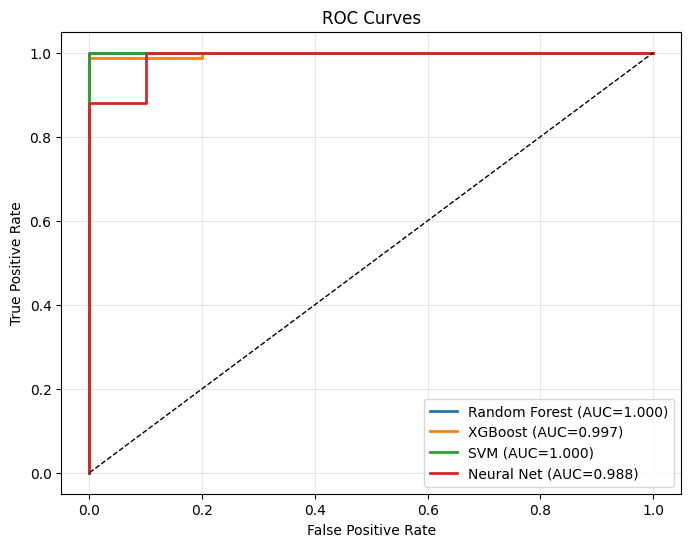

In [29]:
plt.figure(figsize=(8,6))
for name, proba in [
    ("Random Forest", rf_proba),
    ("XGBoost", xgb_proba),
    ("SVM", svm_proba),
    ("Neural Net", nn_pred_proba),
]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_val = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


SHAP explainability for Random Forest 

In [30]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
f1_rf = []
for tr, te in skf.split(Xsel_train, y_train):
    rf_cv = RandomForestClassifier(
        n_estimators=300, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1
    )
    rf_cv.fit(Xsel_train[tr], y_train.iloc[tr])
    pred = rf_cv.predict(Xsel_train[te])
    f1_rf.append(f1_score(y_train.iloc[te], pred))
print(f"RF 10-fold CV F1 (train-folds): mean={np.mean(f1_rf):.4f} ± {np.std(f1_rf):.4f}")


RF 10-fold CV F1 (train-folds): mean=0.9884 ± 0.0130


In [31]:
import pickle
artifacts = {
    "scaler": scaler,
    "discretizer": disc,
    "selector": selector,
    "selected_feature_names": sel_names,
    "dt": dt,
    "rf": rf,
    "xgb": xgb_clf,
    "svm": svm,
    "nn": nn,
    "metrics": {
        "Decision Tree": dt_metrics,
        "Random Forest": rf_metrics,
        "XGBoost": xgb_metrics,
        "SVM": svm_metrics,
        "Neural Net": nn_metrics
    },
    "dataset": DATASET_NAME
}
with open("/kaggle/working/pipeline_artifacts.pkl", "wb") as f:
    pickle.dump(artifacts, f)
results_df.to_csv("/kaggle/working/model_results.csv")
print("Saved: /kaggle/working/pipeline_artifacts.pkl, model_results.csv")


Saved: /kaggle/working/pipeline_artifacts.pkl, model_results.csv


In [32]:
import os
os.chdir(r'/kaggle/working')


In [33]:
!zip -r download_output.zip /kaggle/working


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/selected_features_chi2_scores.csv (deflated 76%)
  adding: kaggle/working/class_distribution.png (deflated 14%)
  adding: kaggle/working/differential_expression_results.csv (deflated 58%)
  adding: kaggle/working/model_results.csv (deflated 45%)
  adding: kaggle/working/differential_expression.png (deflated 10%)
  adding: kaggle/working/confusion_matrices_all_models.png (deflated 18%)
  adding: kaggle/working/pipeline_artifacts.pkl (deflated 43%)
  adding: kaggle/working/class_imbalance_analysis.png (deflated 12%)
  adding: kaggle/working/expression_distribution.png (deflated 11%)
  adding: kaggle/working/binarization_effect.png (deflated 16%)
  adding: kaggle/working/feature_selection_analysis.png (deflated 12%)
  adding: kaggle/working/selected_genes_details.csv (deflated 68%)
  adding: kaggle/working/nn_training_history.png (deflated 13%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/g

In [34]:
from IPython.display import FileLink
FileLink(r'download_output.zip')


/kaggle/working/download_output.zip